# **Full Fine-Tuning Notebook**

### **Full Fine-Tuning Readme:**

For more information on Full Fine-Tuning, refer to the [Full Fine-Tuning Readme](../full_finetuning_readme.md).

### **About This Notebook:**

This notebook demonstrates `Full Fine-Tuning`. Compared to the [LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a40_48g_x1/lora_finetuning.ipynb), the following modifications have been made:

1. Before training, parameters of the base model are directly set as trainable instead of creating a LoRA adapter. The trainable parameters are the linear (`'proj'`) layers in the `text_model` and `connector` modules.
2. After training, the fine-tuned model can be directly loaded from a checkpoint and saved locally, avoiding the need to merge LoRA weights with the base model weights.

### **Supporting Python Files:**

- `my_login.py`: Contains reusable login functions (e.g., for Hugging Face and Weights & Biases). Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a40_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils.py`: Contains general-purpose utility functions for fine-tuning. Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a40_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils_full_finetuning.py`: Contains utility functions specific to full fine-tuning. Created within this notebook.

### **Experiment Settings:**

This experiment is conducted within a pod (container instance) provided by [RunPod](https://runpod.io). The specific configurations are as follows:

- `Template (Docker Container Image)`: runpod/pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04
- `Volume Disk`: 1200GB (model checkpoints storage)
- `GPU Setup`: 1 Nvidia A100 SXM GPU (80GB VRAM)

---
# **Step 1: Preparation**

## 1.1 Install Necessary Python Packages

In [1]:
!python -m pip install -q -U pip            # [optional] upgrade pip
!pip install huggingface_hub==0.25.1 -q -U  # hf lib to login to huggingface and download dataset, model
!pip install hf_transfer==0.1.8 -q -U       # hf lib to speed up huggingface data transfer 
!pip install transformers==4.46.0 -q -U     # hf lib to load model and processor(tokenizer)
!pip install accelerate==0.34.2 -q -U       # hf lib to support 'device_map', restart kernel required after installation
!pip install flash-attn==2.6.3 -q -U        # to reduce vram usage for llama model, restart kernel recommended after installation
!pip install datasets==3.0.0 -q -U          # hf lib to load dataset
!pip install peft==0.13.0 -q -U             # hf lib to support lora fine-tuning
!pip install matplotlib==3.9.2 -q -U        # to plot similarity score comparison graphs
!pip install tensorboard==2.18.0 -q -U      # to support logging with tensorboard
!pip install wandb==0.18.1 -q -U            # to support logging with weights and biases (wandb)
!pip install ipython==8.28.0 -q -U          # to enable %% magic functions in a jupyter notebook


Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet


## 1.2 Restart Kernel to Activate Installed Packages

---
# **Step 2: Pre-training**

## 2.1 Log in to Required Accounts (e.g., Hugging Face, Weights & Biases) 

In [1]:
import my_login
# Log in to the Hugging Face account to access the Idefics2 model and the dataset
my_login.login_hf()
# Log in to the Weights & Biases account to enable tracking of training progress
my_login.login_wandb()

==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 2.2 Load the Processor (Tokenizer) and the Base Model

In [2]:
import my_utils
# Load processor
processor = my_utils.load_processor()
my_utils.print_processor_info_to_file(processor, './results/model_info/original_processor_info.txt')
# Load model
base_model = my_utils.load_model()
my_utils.print_model_info_to_file(base_model, './results/model_info/base_model_info.txt')
my_utils.print_model_parameters_to_file(base_model, './results/model_info/base_model_parameters.txt')

==> Loading processor...


processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32003, bos_token: <s>, eos_token: </s>, pad_token: <unk>
==> For complete processor info, refer to ./results/model_info/original_processor_info.txt.
==> Loading model...


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/base_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, True)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, True)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.k_proj.weight (1327104, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.k_proj.bias (1152, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.v_proj.weight (1327104, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.v_proj.bias (1152, torch.bfloat16, cuda, True)
model.vision_model.encoder.lay

## 2.3 Load the Dataset

In [3]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

==> Loading hf dataset...


README.md:   0%|          | 0.00/648 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/82 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/74 [00:00<?, ? examples/s]

## 2.4 Perform Inference with the Base Model to Establish a Baseline

==> Performing batch inference and saving results to ./results/inference_results/inference_results_before_finetuning.csv ...
==> [Batch: 1/8] Data in batch: 10
==> [Batch: 1/8][Data: 1/10] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


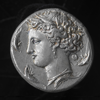

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a coin.
==> Ground truth answer: The exhibit features the Syracuse dekadrachm, a remarkable coin from antiquity renowned for its exquisite artistry and high relief, crafted by notable designers like Kimon and Euinatos. This coin has captivated enthusiasts for over 2,500 years, raising questions about how the ancient Greeks achieved such beauty using only hand tools. An interesting connection to American history is found in Theodore Roosevelt, who, while known for his political reforms, also sought to enhance American coinage. Disappointed by the mundane designs of contemporary coins, he envisioned a more artistic approach that would rival the elegance of classical pieces like the dekadrachm. Roosevelt's

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


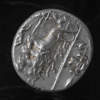

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a coin.
==> Ground truth answer: This exhibit highlights the Syracuse dekadrachm, a stunning ancient coin that exemplifies the artistry of its time, designed by renowned craftsmen such as Kimon and Euinatos. With its striking high relief, this coin has fascinated collectors for more than two millennia, prompting inquiries into the techniques used by the Greeks to achieve such intricate designs without modern tools. A significant figure connected to this coin is Theodore Roosevelt, who, while recognized for his political reform efforts, also sought to elevate the quality of American currency. Frustrated by the lackluster designs of contemporary coins, he advocated for a more artistic 

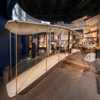

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A full size replica of the Wright brothers first airplane is on display with photos and videos of the brothers flying in the background.
==> Ground truth answer: This exhibit showcases the remarkable 1903 Wright Flyer, the first successful powered airplane, which heralded the beginning of the aerial age. Designed by Wilbur and Orville Wright, this biplane features a 12-horsepower Wright horizontal four-cylinder engine that drives two pusher propellers through a chain-and-sprocket transmission. Notably, it employs linear skids for landing gear and is finished with natural fabric, devoid of any sealant or paint. The Wright brothers' groundbreaking achievement on December 17, 1903, at Kitty Hawk, North Carolina, i

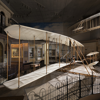

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A collection of old fashioned planes are on display in a museum.
==> Ground truth answer: The exhibit features the iconic 1903 Wright Flyer, a pioneering aircraft that marked the dawn of powered flight. Built by the Wright brothers, Wilbur and Orville, this biplane is powered by a 12-horsepower engine that operates two pusher propellers via a sprocket-and-chain system. Its unique landing gear consists of linear skids, and it is covered in natural fabric, without any paint or sealant. The Flyer made its historic first flight on December 17, 1903, in Kitty Hawk, North Carolina, with Orville at the controls for a brief 12-second journey. The Wrights' innovative methods, including wind tunnel te

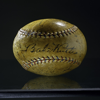

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a ball on the surface.
==> Ground truth answer: This exhibit features a remarkable autographed baseball from the legendary 1926 New York Yankees, signed by iconic players including Hall of Famers Babe Ruth and Lou Gehrig. Ruth, known for his extraordinary hitting prowess, and Gehrig, celebrated for his record of 2,130 consecutive games played, both left an indelible mark on the sport. Gehrig's battle with amyotrophic lateral sclerosis (ALS), which is often referred to as Lou Gehrig's disease, showcased his incredible humility and resilience, inspiring many during his illness. The baseball, which measures approximately 3 inches in diameter, is crafted with a cork center, wool layers, and

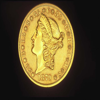

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a coin with some text and numbers on it.
==> Ground truth answer: This exhibit features a remarkable coin from the United States Mint in Philadelphia, showcasing a unique design that reflects a significant moment in American numismatic history. The obverse displays the Liberty head facing left, with the date inscribed below and details about weight and fineness surrounding it. The reverse features an eagle, similar to the standard twenty-dollar coin, but replaces the traditional motto "IN GOD WE TRUST" with "DEO EST GLORIA." This coin was part of a series inspired by the desire to enhance the competitiveness of American currency in global markets, alongside the creation of the four-doll

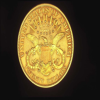

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a golden coin and I can see a logo on it.
==> Ground truth answer: This exhibit highlights a significant gold coin minted by the United States Mint in Philadelphia, showcasing both artistic and economic significance. The coin features a Liberty head on the obverse, with the date inscribed below and weight and fineness details surrounding it. On the reverse, an eagle is depicted, but intriguingly, it bears the Latin phrase "DEO EST GLORIA" instead of the more familiar "IN GOD WE TRUST." This design was part of an initiative aimed at improving the international appeal and convertibility of American coins, paralleling the introduction of the four-dollar gold coin, or Stella. Only nine g

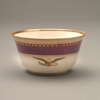

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This small cup has a purple band at the top and a design of an eagle on the front.
==> Ground truth answer: The exhibit features Abraham Lincoln's coffee cup, a poignant artifact from a pivotal moment in American history. This ceramic cup, adorned in purple with white and gold trim, was left behind by President Lincoln on a windowsill at the White House on the evening of April 14, 1865, just before he attended Ford's Theatre. A White House servant preserved this cup as a memento of that tragic night, which marked the end of Lincoln's life and the Civil War. In 1887, Captain D.W. Taylor gifted it to Robert Todd Lincoln, the president's eldest son, ensuring its legacy as a cherished family heirloom. The cup is no

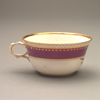

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This cup has a handle and is purple next to the gold.
==> Ground truth answer: This exhibit showcases a significant artifact: Abraham Lincoln's coffee cup, which dates back to 1887. The cup was a gift from Captain D.W. Taylor to Robert Todd Lincoln, the president's eldest son. It holds a somber history, as it was left behind by Lincoln on April 14, 1865, just before he went to Ford's Theatre for what would be his final evening. A White House servant preserved the cup, recognizing its importance as a relic of that fateful night. Crafted from ceramic and featuring a striking purple color with white and gold trim, the cup measures approximately 3 1/4 inches in height. It is housed at the Smiths

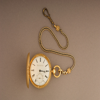

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A watch with a gold chain is on a gray surface.
==> Ground truth answer: This exhibit features a remarkable English gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite timepiece served as a notable emblem of his achievements as a lawyer. The watch's movement, crafted in Liverpool, represents the high-quality manufacturing of the era, while the case was made by an unidentified American artisan. Notably, this watch boasts one of the finest movements available in England, capable of maintaining accurate time to within seconds daily. A hidden narrative unfolds with engravings made by watchmaker 

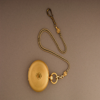

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: Gold watch with chain on a brown background.
==> Ground truth answer: This exhibit showcases Abraham Lincoln's gold pocket watch, acquired in the 1850s from a jeweler named George Chatterton in Springfield, Illinois. Although Lincoln was not typically seen as vain, the watch symbolized his professional success as a lawyer. The watch's movement was produced in Liverpool, a hub for watchmaking at the time, while the case was crafted by an unidentified American shop. Known for its exceptional quality, the watch's movement can keep time within seconds daily. A fascinating aspect of this piece is the hidden message engraved by watchmaker Jonathan Dillon, who, during repairs on April 12, 1861, ins

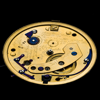

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a watch.
==> Ground truth answer: This display features an exquisite gold pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a prestigious symbol of his accomplishments as a lawyer. The watch's movement was manufactured in Liverpool, a center of watch production, and it is accompanied by a high-quality case made in America. Remarkably, this timepiece has a movement capable of keeping time to within seconds each day. An intriguing story lies within, as watchmaker Jonathan Dillon, while repairing the watc

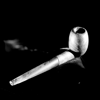

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image I can see a pipe on the table.
==> Ground truth answer: The exhibit features Albert Einstein's iconic pipe, dating back to around 1948. Known for his groundbreaking contributions to theoretical physics, including the theory of relativity, Einstein is also recognized for his distinctive appearance, which prominently included this pipe. Despite reducing his smoking due to medical advice in his later years, he cherished the physical sensation of holding a pipe. This particular pipe shows signs of extensive use, with a noticeable hole worn into its bit. It was gifted to Gina Plunguian, a close friend and admirer of Einstein, before being acquired by the Smithsonian in 1979. This artifact is part of a 

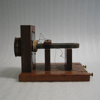

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a device that produces an electric current.
==> Ground truth answer: This exhibit at the National Museum of American History highlights the groundbreaking invention of the telephone by Alexander Graham Bell. On March 7, 1876, Bell was awarded the first patent for an apparatus designed to transmit vocal sounds telegraphically. Just three days later, he successfully communicated with his assistant, Thomas Watson, uttering the iconic words, “Mr. Watson, come here, I want to see you.” Featured in this exhibit is one of the original telephones used during a demonstration between Boston and Salem, Massachusetts, on November 26, 1876. This particular device is notable for its iron diaphragm and dual electromag

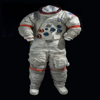

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a mannequin wearing a space suit.
==> Ground truth answer: This exhibit features the Apollo 17 spacesuit, which was worn during the final Apollo mission that successfully landed astronauts on the moon in 1972. Launched on December 7, 1972, aboard a Saturn V rocket, Apollo 17 included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, notable for being the only geologist to have walked on lunar soil. While Evans orbited the moon, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region, where they conducted extensive scientific activities over three days. They completed three moonwalks, collecting a remarkable 110 kil

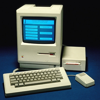

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The computer has a blue screen with several windows on it.
==> Ground truth answer: This exhibit features the iconic Apple "Classic" Macintosh Personal Computer, launched in 1984 by Apple Inc. This groundbreaking machine introduced a graphic user interface (GUI) to the world of personal computing, a concept that had its roots in the 1970s at Xerox's Palo Alto Research Center. Apple captured public attention with a memorable Super Bowl XVIII advertisement, marking the Macintosh's debut on January 22, 1984, with a retail price of approximately $2,500. Unlike previous computers that relied on command lines, the Macintosh allowed users to interact with programs through clickable icons, utilizing a single-button mou

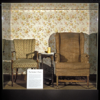

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a glass box. In this box there are two chairs. On this table there is a cup.
==> Ground truth answer: This exhibit features an iconic upholstered wing chair that was prominently used by the character Archie Bunker, portrayed by Carroll O'Connor, in the groundbreaking television series "All in the Family." The chair, with its distinctive orange-yellow woven fabric and sturdy wooden frame, dates back to the 1940s, although its exact origins remain unclear. Initially acquired from a thrift store in Southern California, it served as a significant prop throughout the show's run from 1971 to 1979, until it was replaced by a reproduction in the final season after being donated to the Smithsonian. "All in the F

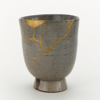

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This bowl is part of the collection of the Asian Art Museum of San Francisco. It is made of stoneware and is grey in color. There are gold lines on the bowl.
==> Ground truth answer: This exhibit features a remarkable 17th-century tea bowl from the Satsuma ware collection, specifically the White Satsuma type, hailing from Kagoshima prefecture in Japan during the Edo period. The bowl, made of stoneware and finished with a clear, crackled glaze, has a storied past, having been broken and subsequently repaired using the traditional Japanese art of kintsugi, or golden joinery. This technique not only mends the bowl but also accentuates its history by highlighting the cracks with lacquer infused with powdered gold. 

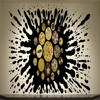

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting.
==> Ground truth answer: This exhibition features the captivating work of Yinka Shonibare, a prominent artist born in London in 1962. The display showcases 25 circular canvases of varying sizes, meticulously arranged over a large-scale ink splatter pattern that has been applied using a template. Each canvas is adorned with intricate foliate designs painted in black and gold, utilizing Dutch wax printed fabrics. Shonibare's earlier works are characterized by small square canvases in a grid layout, while his more recent pieces, including this one, challenge traditional boundaries with their dynamic black splatter forms. The artwork draws inspiration from Africa's oil resources, often referred 

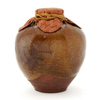

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a brown vase with a brown and red design on it.
==> Ground truth answer: The exhibit titled "Chigusa and the Art of Tea," located at the Arthur M. Sackler Gallery, delves into the intricate relationship between Japanese tea culture and the art of collecting. It highlights how collectors engaged with tea-leaf storage jars through the traditional tea ceremony, known as chanoyu, by bestowing names and adorning these jars with exquisite textiles. Central to this theme is the jar named Chigusa, which evolved from a simple Chinese import into a revered object of beauty and contemplation, while still retaining its functional purpose. Notably, 16th-century tea diaries provide insights into the admiration expres

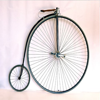

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A penny farthing bicycle is on display.
==> Ground truth answer: This exhibit at the National Museum of American History celebrates the arrival of spring with a spotlight on an original 1886 Columbia Light Roadster high-wheel bicycle. This remarkable artifact, which originally sold for around $135, was produced by the Pope Manufacturing Co., recognized as the first bicycle manufacturer in the United States. The bicycle features a distinctive configuration with a 53-inch front wheel, supported by 60 spokes, and an 18-inch rear wheel with 20 spokes, available in a range of sizes for riders. Accompanying this bicycle is a historic photograph showcasing one of America's inaugural organized biking tours from 1879, f

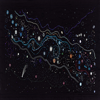

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting. In this painting, we can see some objects.
==> Ground truth answer: The exhibit titled “Milky Way, Starry Night # 2” features the work of Gwich'in artist Margaret Nazon, who hails from Tsiigehtchic in the Northwest Territories of Canada. Created in 2021, this piece reflects Nazon's lifelong fascination with the stars, a passion that she fully embraced in her art later in life after being inspired by Hubble Space Telescope imagery. Nazon's work is distinctive as it incorporates swirling galaxies, a departure from traditional Gwich'in beadwork, showcasing her unique artistic style. This artwork is part of the “Lights Out: Recovering Our Night Sky” exhibition at the Smithsonian's National Museu

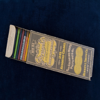

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a box which contains crayons.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights a pack of Crayola Crayons from 1903, celebrating a beloved back-to-school tradition. Invented by cousins Edwin Binney and C. Harold Smith, the crayons were crafted using paraffin wax and nontoxic pigments, making them safe and durable for young artists. The name "Crayola," created by Alice Binney, combines the French word for chalk, "craie," with "oleaginous," referring to its waxy texture. This particular set, aimed at budding artists, features 28 vibrant colors, including celestial blue and rose pink, and is one of the earliest produced. The packaging, la

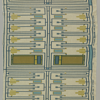

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a poster. In this poster we can see some text and some designs.
==> Ground truth answer: This exhibit features a striking piece designed by the renowned American architect Frank Lloyd Wright, who lived from 1867 to 1959. The textile, produced by F. Schumacher & Co., a New York-based manufacturer established in 1889, showcases a captivating geometric pattern composed of rectangular blocks in shades of light blue and various olive tones, intricately connected by fine lines of darker blue against an off-white backdrop. The length of the printed linen measures 120 by 57.5 cm (47 1/4 by 22 5/8 inches), with a repeat height of 63.5 cm (25 inches). Additionally, five alternate colorways of this design are affi

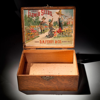

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a wooden box with a painting on it.
==> Ground truth answer: This exhibit features an antique seed box from the late 19th century, specifically from the renowned D.M. Ferry & Co., and is part of the Smithsonian's celebration of National Garden Month. In the 1800s, seed packets were commonly stored in decorative wooden boxes that showcased vibrant labels from seed companies, serving as effective marketing tools on general store counters. This particular seed box, which showcases the D.M. Ferry & Co. label, is significant for its association with the invention of the “commission box,” a display rack that revolutionized retail presentation. Acquired by the Smithsonian in 1986, this artifact highlights the 

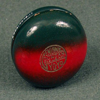

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A red and black item is marked with the words Gunning YoYo.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights the captivating story of the yo-yo, a toy that gained immense popularity in America thanks to Chicago businessman Donald F. Duncan Sr. In 1928, Duncan discovered the yo-yo during a business trip to San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant. Flores had begun manufacturing the toy, which he named “yo-yo,” meaning “come-come” in Tagalog. By early 1929, he had established his own company and produced over 100,000 wooden yo-yos, recognizing the need for demonstrations to attract buyers. Duncan, an astute entrepreneur, 

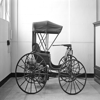

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a black and white image. In this image we can see a vehicle on the floor. In the background we can see a wall and a window.
==> Ground truth answer: The exhibit features the 1893-94 Duryea automobile, recognized as one of the earliest American-made vehicles. On September 21, 1893, Frank Duryea conducted a road test of this innovative automobile, which was essentially a second-hand carriage outfitted with a gasoline engine, in Springfield, Massachusetts. In 1896, Frank and his brother Charles, along with financial partners, established the Duryea Motor Wagon Company, marking it as the first American enterprise to manufacture and sell automobiles. This particular model is powered by a one-cylinder, four-c

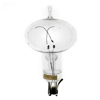

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a bulb.
==> Ground truth answer: This exhibit showcases the Edison Light Bulb, which dates back to 1879 and represents a pivotal moment in the history of innovation. Thomas Edison utilized this carbon-filament bulb during the inaugural public demonstration of his groundbreaking invention—the light bulb, recognized as the first viable electric incandescent lamp. The mechanism of the bulb involves an electrical current flowing through a metal filament wire, which heats up to an intense temperature, ultimately producing light. To safeguard the hot filament from oxygen, the bulb is encased in glass filled with inert gas. This significant demonstration took place at Edison's laboratory in Menlo Park, New Jer

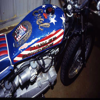

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A harley davidson motorcycle with an american flag paint job.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History showcases Evel Knievel's iconic 1972 Harley-Davidson XR-750, a motorcycle synonymous with the legendary daredevil's thrilling performances. Evel Knievel, born Robert Craig Knievel, captivated audiences with his death-defying stunts, which often resulted in numerous injuries, including 35 to 40 broken bones throughout his career. His televised daredevil shows, beginning in 1965, featured spectacular jumps over rows of vehicles, including cars, trucks, and buses. The XR-750, constructed from steel, aluminum, and fiberglass, weighs around 300 pounds and was pi

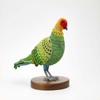

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a toy of a bird.
==> Ground truth answer: The exhibit features Laurel Roth Hope's intriguing work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece cleverly employs humor to highlight the grave issue of species extinction. Through her “Biodiversity Reclamation Suits,” Hope enables common rock pigeons to don the guise of extinct North American birds, symbolically addressing the loss of biodiversity. Utilizing traditional crafting techniques such as carving, embroidery, crochet, and collage, she transforms everyday materials into striking animal sculptures that evoke both playfulness and a deeper emotional response. 

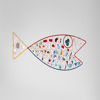

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting of a fish.
==> Ground truth answer: This exhibit features "Fish," a captivating work by renowned artist Alexander Calder, created in 1945 and housed at the Hirshhorn Museum and Sculpture Garden in Washington, D.C. Calder, who was born into a family of artists and initially trained as a mechanical engineer, transitioned to art after working as a freelance illustrator. His journey took him to Paris, where he became inspired by avant-garde movements and began crafting his signature wire sculptures, often referred to as “drawings in space.” Influenced by the minimalist aesthetic of Piet Mondrian, Calder pioneered the concept of “mobiles” in 1931—kinetic sculptures that move with air currents. He 

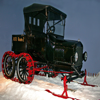

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a vehicle on the snow.
==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a 1921 Ford Model T equipped with a unique snow attachment, highlighting the ingenuity of early 20th-century rural mail carriers. As these carriers transitioned from horse-drawn sleds to automobiles, they faced challenges navigating deep snow. In response, Virgil White innovated by converting cars into snowmobiles, replacing front tires with skis and rear tires with caterpillar treads. His invention, dubbed the Snowbird, provided a cost-effective solution for winter deliveries, eliminating the need for horses. Initially, White's prototype was based on a Buick Model G, but as the Ford Model 

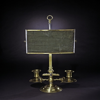

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image I can see a stand and on it I can see two candles. I can also see this image is little bit in dark.
==> Ground truth answer: This exhibit showcases a significant artifact linked to George Washington, specifically a brass candle stand believed to have been used by him while composing his Farewell Address in 1796. After serving two terms as president, Washington chose to retire to Mount Vernon, where he penned his final thoughts for the nation, urging unity among Americans amidst emerging political factions. His Farewell Address was first published in The American Daily Advertiser and has since been commemorated annually by the United States Senate, where a member reads it aloud in honor of Washingt

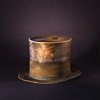

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a hat.
==> Ground truth answer: This exhibit features President Abraham Lincoln's iconic top hat, housed at the Smithsonian's National Museum of American History. Acquired from Washington hat maker J.Y. Davis, this hat stands as a symbol of Lincoln's stature, both physically at 6'4” and in his leadership. Notably, a black silk mourning band adorns the hat, honoring the memory of his son Willie, who passed away in 1862. While the exact date of acquisition remains unknown, the hat was last worn by Lincoln on the fateful night of April 14, 1865, as he headed to Ford's Theatre. Following Lincoln's assassination, the War Department safeguarded the hat along with other belongings left behind, later transferri

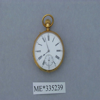

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A pocket watch with roman numerals is displayed above a label that says ME*335239.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History features a remarkable timepiece belonging to Helen Keller, who was born on June 27, 1880. Keller, a pivotal figure in advocating for women's suffrage and workers' rights, faced significant challenges after losing her sight and hearing due to illness at a young age. Her breakthrough came with the help of Anne Sullivan, who taught her to communicate. The Swiss-made "touch watch," gifted to Keller by John Hitz in 1892, is designed with pins around its edge to indicate the hours, allowing Keller to tell time even in darkness. This unique wa

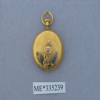

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A gold pocket watch is on display above a label that says ME*335239.
==> Ground truth answer: This exhibit showcases an extraordinary pocket watch that once belonged to Helen Keller, who was born on June 27, 1880. Keller, known for her advocacy for women's rights and disability rights, faced immense challenges after becoming deaf and blind at a young age. Her life changed dramatically when she met Anne Sullivan, who taught her to communicate. The watch, presented to Keller by John Hitz in 1892, features a unique design with pins around the case that allow the wearer to feel the time, making it particularly suitable for someone who could not see. Keller cherished this watch throughout her lif

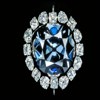

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a diamond pendant.
==> Ground truth answer: This exhibit features a stunning diamond necklace crafted by Cartier, Inc., showcasing a primary gem that weighs an impressive 45.52 carats. The diamond, characterized by its dark gray-blue hue, is cut in a modified antique cushion style, which enhances its unique visual appeal. Originating from India, this exquisite piece is part of the Mineral Sciences collection, specifically within the Gems category at the National Museum of Natural History. The necklace is cataloged under the USNM number NMNH G3551-00 and is a singular specimen in this exhibit, last modified on September 26, 2022. For more detailed information, you can access the original record through t

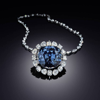

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This necklace contains the largest blue diamond in the world.
==> Ground truth answer: This exhibit showcases a remarkable diamond necklace by Cartier, Inc., featuring a single primary gem that weighs 45.52 carats. The diamond is distinguished by its dark gray-blue color and is elegantly cut in a modified antique cushion shape, which adds to its vintage charm. Sourced from India, this necklace is a highlight of the Mineral Sciences collection at the National Museum of Natural History, categorized under Gems. The record for this exquisite piece is identified as NMNH G3551-00 and was last updated on September 26, 2022. For further details, you can explore the original record linked here.
==> S

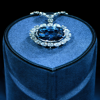

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a necklace on the blue color cloth.
==> Ground truth answer: On display is a captivating diamond necklace by Cartier, Inc., featuring a single, striking primary gem that weighs 45.52 carats. This diamond exhibits a dark gray-blue coloration and is expertly cut in a modified antique cushion style, making it a true work of art. The necklace hails from India and is part of the Mineral Sciences department's Gems collection at the National Museum of Natural History. It is cataloged under the USNM number NMNH G3551-00, with the last modification recorded on September 26, 2022. For more in-depth information, you can follow the link to the o

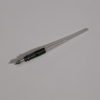

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a pen.
==> Ground truth answer: This exhibit features an Esterbrook pen that holds significant historical importance as it was used by President Lyndon B. Johnson to sign the Civil Rights Act of 1964 on July 2 of that year. Part of the Smithsonian's National Museum of African American History and Culture collection, this particular pen was among over 70 identical pens distributed to key figures in the Civil Rights Movement. The journey to the enactment of this landmark legislation was fraught with challenges, initially introduced by President John F. Kennedy before his tragic assassination in November 1963. The bill's fate then rested with President Johnson, who oversaw lengthy public hearings and debat

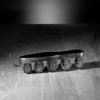

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a toy on the surface.
==> Ground truth answer: This exhibit features the Volito, an innovative inline skate crafted in 1823 by Robert John Tyers. As athletes prepare for the 2014 Winter Olympics, it's intriguing to consider how skaters of the 19th century maintained their skills without the luxury of indoor rinks. The Volito is distinguished by its wooden sole, a single row of five wooden wheels, and a unique curved iron bar at the front, which functioned as a basic brake. What truly set this skate apart was its unequal wheel sizes—larger in the center and smaller at the ends—allowing skaters to navigate turns with greater ease. This remarkable design reflects the ingenuity of early spo

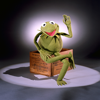

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a toy of a frog. This toy is placed on a wooden box.
==> Ground truth answer: This exhibit showcases Kermit the Frog, a beloved character created by Jim Henson, who has become an iconic figure in children's television. Kermit, a vibrant green puppet, first appeared in 1955 on the show "Sam and Friends" and has since been the star of "The Muppet Show" and a regular on "Sesame Street." Known for his calm demeanor amidst chaos, Kermit is famous for his poignant song “Bein' Green,” which reflects on the challenges of his color while ultimately celebrating his identity. The puppet is crafted from various materials, including synthetic fiber, felt, and plastic, and measures approximately 27 inches in height. 

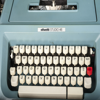

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A blue, Olivetti Studio 46, typewriter with a single red key.
==> Ground truth answer: This exhibit features the typewriter of Octavia Estelle Butler (1947–2006), a celebrated author in the realm of science fiction. Butler is renowned for her impactful works, including the five-volume Patternist series, the Xenogenesis trilogy—also known as Lilith's Brood—and the thought-provoking novels Parable of the Sower and Parable of the Talents, along with her acclaimed short story collection, Bloodchild and Other Stories. Her writing uniquely blended elements of African American history with speculative futures and alien psychology, establishing a genre known as Afrofuturism. By centering characters 

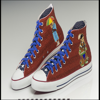

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: These are the shoes which are in red color.
==> Ground truth answer: This exhibit features a remarkable piece titled "Kiowa Ah-Day," created by Kiowa artist Teri Greeves in 2004. The artwork, which takes the form of sneakers, is a unique blend of traditional and contemporary materials, incorporating cotton canvas, glass beads, and commercial rubber. Measuring 33 x 11 x 15 cm, this piece exemplifies Greeves' innovative approach, showcasing overlay beadwork that reflects the rich cultural heritage of the Kiowa people. Acquired by the National Museum of the American Indian from Thirteen Moons Gallery in Santa Fe, New Mexico, this work is part of a broader collection that highlights the intersection of indigenous a

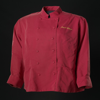

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a red color jacket.
==> Ground truth answer: This exhibit showcases a significant collection from the Smithsonian's National Museum of African American History and Culture, featuring a gift from Dooky Chase's Restaurant and renowned Chef Leah Chase. Celebrated for her assertion that “we changed the world over a bowl of gumbo,” Chase played a pivotal role in the civil rights movement by hosting strategy meetings at her restaurant. Known as "The Queen of Creole Cuisine," she elevated New Orleans Creole cooking to global prominence. Alongside her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop established by her mother-in-law in the 1940s into an elegant dining venue a

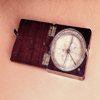

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a compass.
==> Ground truth answer: This exhibit showcases a remarkable silver-plated pocket compass that dates back to around 1804, purchased by Meriwether Lewis in preparation for the historic Lewis and Clark Expedition. Crafted by Philadelphia instrument maker Thomas Whitney, the compass features a mahogany box, a brass rim graduated in degrees, a paper dial, and two brass sight vanes, all housed in a leather carrying case. While it remains uncertain whether Lewis intended the compass for himself or as a gift for his expedition partner, William Clark, it served as a vital navigational tool during their journey. Under President Thomas Jefferson's directive, the Corps of Discovery embarked on their mis

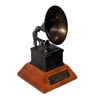

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a trophy.
==> Ground truth answer: This exhibit showcases Bob Newhart's 1960 Grammy Award, a significant artifact from the celebrated comedian's illustrious career. Born on September 5, 1929, in Oak Park, Illinois, Newhart has entertained audiences for over sixty years with his signature deadpan style, cleverly critiquing social norms and the absurdities of American life. His groundbreaking comedy album, The Button-Down Mind of Bob Newhart, made history by becoming the first comedy LP to reach No. 1 on the Billboard charts and won him a Grammy for Album of the Year, making him the only comedian to win a Grammy for Best New Artist. Newhart's influence extended into television, where he starred in iconic 

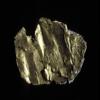

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a gold leaf.
==> Ground truth answer: This exhibit features a remarkable gold nugget from 1848, housed at the Smithsonian's National Museum of American History. Regarded as the first gold piece discovered at Sutter's Mill in California, this nugget played a pivotal role in sparking the infamous gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall noticed a glimmer in the water and retrieved what he identified as a thin scale of pure gold. Following this discovery, Marshall presented the scale to Capt. Joseph L. Folsom, who documented it as the first gold found in Northern California. By August of that year, this nugget, along with other samples, reached Washingt

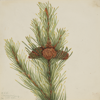

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting. In this painting, we can see a plant with some fruits.
==> Ground truth answer: This exhibit showcases the exquisite watercolor work of Mary Vaux Walcott, particularly her piece titled "Lodgepole Pine (Pinus Contorta murrayana)" created in 1921. Measuring 10 x 7 inches, this artwork is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration began when a botanist encouraged her to paint a rare blooming arnica. Her marriage to Charles Doolittle Walcott, the Smithsonian's Secretary, in 1914 led to summers spent in the Canadian Rockies, where she produced hundreds of watercolor studies of local flora. From 1925 to 1929

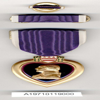

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A Purple Heart is shown with a bronze star and a blue ribbon.
==> Ground truth answer: This exhibit features the esteemed United States Purple Heart, a distinguished military decoration awarded to those wounded or killed while serving in the U.S. armed forces. The medal is crafted in a striking gold heart shape, showcasing a profile relief of George Washington at its center, set against a rich purple enamel background. Above Washington's bust, the medal is adorned with a shield displaying his family coat of arms. The reverse side bears the embossed inscription "FOR MILITARY MERIT," highlighting the medal's significance. It is suspended from a silk purple ribbon, edged with a white stripe, adding to its elegance

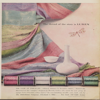

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a poster. On the poster there is a cloth. Also there is a vase. And there are threads. Also there is some text.
==> Ground truth answer: This exhibit, titled "The Thread of the Story Is Lurex: The Look of Porcelain," showcases the work of renowned American textile designer Dorothy Liebes, who significantly influenced various design disciplines from the 1930s to the 1960s. Known for her vibrant colors and rich textures, Liebes developed a distinctive style that became synonymous with the modern American aesthetic, referred to as the “Liebes Look.” Her collaborations with notable architects and designers, such as Frank Lloyd Wright and Raymond Loewy, as well as fashion icons like Pauline 

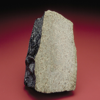

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a large rock that is textured and colored unevenly.
==> Ground truth answer: This exhibit features a fragment of the Nakhla meteorite, which is significant as one of the thirty-four meteorites believed to have originated from Mars. The Nakhla meteorite fell to Earth on June 28, 1911, around 9 a.m. in Alexandria, Egypt, where it was observed exploding in the atmosphere before landing in approximately 40 pieces, weighing a total of 22 pounds. These fragments were found buried up to a meter deep in the ground. The Smithsonian acquired two samples shortly after the fall, and in 1962, it added a 480-gram piece to its collection, totaling 650 grams of Nakhla fragments by the 1970s. The Nakhlites, named after 

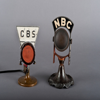

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: Two old fashioned microphones with one saying CBS and one saying NBC.
==> Ground truth answer: This exhibit features a significant artifact from the era of President Franklin D. Roosevelt's "Fireside Chats," a series of informal radio addresses he delivered to the American public starting on March 12, 1933. With the nation grappling with the Great Depression, Roosevelt's ability to communicate directly with citizens through radio became a vital tool for shaping public opinion and providing reassurance. The exhibit highlights an RCA Type 50-A microphone, adorned with the National Broadcasting Company logos, which was used during these broadcasts. Acquired by the museum in 1996, this microphone was preserved by C

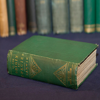

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A green book with gold lettering sits in front of many other books.
==> Ground truth answer: This exhibit showcases "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the May 11, 1820, anniversary of the HMS Beagle's launch, the vessel that carried Darwin on his pivotal scientific journey. The Beagle was launched from the Woolwich Dockyard in London and underwent several adaptations before embarking on its second survey voyage on December 27, 1831. Darwin, a young naturalist, joined the crew to provide geological insights, and his extensive research during the five-year expedition to South America and the Galápagos Is

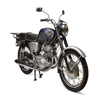

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a motor bike.
==> Ground truth answer: This exhibit features Robert M. Pirsig's iconic 1966 Honda Super Hawk motorcycle, prominently showcased at the Smithsonian's National Museum of American History. This motorcycle is not just a vehicle; it is a symbol of the philosophical journey outlined in Pirsig's influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974, the book quickly became a bestseller, selling over a million copies within its first year and igniting a cultural movement that encouraged individuals to reevaluate their relationship with technology and seek a harmonious existence. The inspiration for "Zen" arose from a transformative r

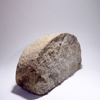

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a rock.
==> Ground truth answer: The exhibit features the Plymouth Rock Piece, a significant artifact housed at the National Museum of American History, which is believed to be linked to the landing of the Mayflower Pilgrims in 1620. According to tradition, this rock marks the site where William Bradford and his fellow settlers first arrived in Plymouth, Massachusetts. Bradford, who played a pivotal role as a leader and governor of the Plymouth Colony, is also credited with the establishment of Thanksgiving as it is celebrated in the United States today. The rock has a storied past, having been relocated in 1774 from its original position to the town square, where it unfortunately split into two halves.

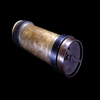

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image I can see a cylindrical object which is black, brown and silver in color. I can see the black colored background.
==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a Pneumatic Mail Container from 1953, a fascinating relic of a bygone era when cities utilized pneumatic tube systems for mail delivery. Originating in the late 1890s, these systems were ingeniously designed to transport mail through underground tubes, with each canister capable of holding up to 500 letters. The canisters, or carriers, were propelled by compressed air, allowing them to travel at speeds averaging 35 miles per hour. At the height of their operation, these systems facilitated the m

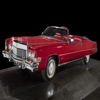

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image I can see a red colour car on the black colour surface.
==> Ground truth answer: The "Rock 'n' Roll Ride" exhibit at the Smithsonian's National Museum of African American History and Culture showcases a remarkable piece of musical history: Chuck Berry's striking red 1973 Cadillac Eldorado. This vehicle is prominently featured in the museum's "Musical Crossroads" exhibition. The Cadillac was a cherished part of Berry's personal collection and gained fame during the filming of the 1987 documentary "Hail! Hail! Rock 'n' Roll," directed by Taylor Hackford. The film captures the essence of two concerts held in 1986 to honor Berry's 60th birthday, and it features a memorable moment when Berry drove this

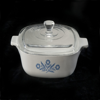

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: White pot with a blue flower design by pyrex.
==> Ground truth answer: This exhibit features a quintessential kitchen item often associated with holiday gatherings—a white casserole dish made by CorningWare in 1965. Adorned with the iconic blue cornflower motif, this dish represents a blend of innovation and tradition. Originally created for military use during World War II, CorningWare's Pyroceram material later emerged as an ideal choice for bakeware, thanks to its ability to endure rapid temperature shifts and resist stains and odors. Its versatility allowed it to transition seamlessly from cooking to freezing to serving, making it a beloved tool in many kitchens. In the 1990s, the brand 

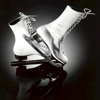

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a pair of skates on the surface.
==> Ground truth answer: This exhibit features the autographed ice skates of Sonja Henie, a pioneering figure in women's figure skating, dating back to around 1945. Henie, a Norwegian skater, revolutionized the sport in the late 1920s and 1930s by introducing white leather skates, a significant departure from the traditional black skates. Her enchanting performances earned her the first of ten consecutive world titles in 1927, where she captivated audiences with her innovative dance style. Henie's influence extended beyond the rink; she was the first to blend choreography with figure skating and popularized the short skirt and white skate aesthetic that 

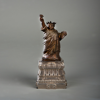

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a statue of liberty.
==> Ground truth answer: This exhibit features one of the earliest models of the Statue of Liberty, often referred to as the American Committee Model. Crafted in the United States, this statuette was produced in large quantities, with tens of thousands sold to raise funds for the construction of the statue's pedestal in New York Harbor. The design, created by French sculptor Frédéric-Auguste Bartholdi, was made available in both six-inch and twelve-inch sizes, with a national newspaper campaign promoting them at one dollar and five dollars respectively. Richard Butler, a rubber manufacturer from New York, led the American Committee overseeing the production of these models. This ini

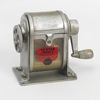

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a machine.
==> Ground truth answer: The exhibit features the Dexter Model 3 Pencil Sharpener, crafted around 1920 by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. This charming artifact, made from metal, cellulose, and painted wood, measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). A gift from Lucy Commoner, it holds a significant place in the Cooper Hewitt, Smithsonian Design Museum collection, although it is not currently on display. As the back-to-school season approaches, this sharpener evokes nostalgia for many, reminiscent of countless school days. The Dexter Model 3 was an evolution of earlier designs, featuring a rotating wheel with calibrated 

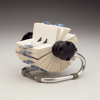

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A round item with cards on it including one that says CARD FILE.
==> Ground truth answer: This exhibit features the iconic Rolodex Open Rotary Card File, a quintessential office supply that revolutionized the way people organized their business contacts before the advent of digital technology. Manufactured by the Rolodex Corporation in the USA, this particular model is crafted from bent tubular metal, molded plastic, rubber, and paper, measuring 18 x 18 x 16.5 cm. The Rolodex operates on a cylindrical design, allowing users to easily flip through A-Z index cards to find contact information. Despite the rise of smartphones and computers, the Rolodex remains a relevant tool in modern workplace

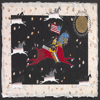

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a painting.
==> Ground truth answer: The exhibit features the "Lakota Horse Mask," created in 2008 by Jim Yellowhawk, a member of the Cheyenne River Lakota tribe. This striking piece, which utilizes acrylic on paper and gold leaf, symbolizes the profound relationship between American Indians and horses, which many tribes refer to as the Horse Nation. Horses were not only allies in times of peace but also played a vital role during conflicts, deeply influencing the cultural landscape of various tribes. Interestingly, horses first emerged in the Americas over 40 million years ago, later becoming extinct before being reintroduced by Columbus in 1493. Today, this artwork is part of the coll

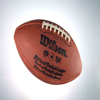

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a football.
==> Ground truth answer: This exhibit features the iconic Wilson Duke football, which has been the official ball of the Super Bowl since Super Bowl II in 1968. The football on display was specifically used during Super Bowl XIV, held at the Rose Bowl in Pasadena, California, on January 20, 1980. In this thrilling game, the Pittsburgh Steelers triumphed over the Los Angeles Rams with a score of 31-19, marking the Steelers' fourth Super Bowl victory. Notably, it was also the second consecutive year that quarterback Terry Bradshaw earned the Most Valuable Player award. The Wilson Duke football, known for its premium leather and durable construction, was introduced by Wilson Spo

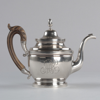

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a silver teapot with a monogram of AH engraved on it.
==> Ground truth answer: This exhibit features a remarkable silver teapot created by American artisan Peter Bentzon, dating from approximately 1817 to 1829. The teapot showcases an elegant oval vase shape, supported by a spreading pedestal foot. Its design includes a gracefully curved spout, which is topped with an incised patera, and a scroll handle adorned with wooden leaf caps. The hinged domed lid is finished with an acorn finial, adding to its aesthetic appeal. Notably, the piece bears the scripted monogram "MC" engraved on its side, alongside the name "Rebecca Dawson" inscribed along the bottom rim. This exquisite object is part of the National

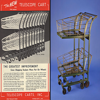

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a poster. On the left side there is a trolley cart. On the right side there is a poster.
==> Ground truth answer: The exhibit at the National Museum of American History features the innovative Telescoping Shopping Cart, designed by Orla E. Watson in 1946. This clever invention, first introduced in 1947 at Floyd's Super Market in Kansas City, Missouri, revolutionized the way consumers shop by allowing carts to nest together for efficient storage. Watson asserted that these new carts utilized only one-fifth of the space of traditional carts when parked, making them a practical solution for busy shoppers. This display is part of the Smithsonian's inaugural major exhibition on food history, which delves int

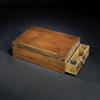

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a wooden box with two drawers.
==> Ground truth answer: This exhibit showcases the portable writing desk designed by Thomas Jefferson, which he used to draft the Declaration of Independence in 1776. The desk features a hinged writing board and a locking drawer for storing essential writing materials such as papers, pens, and an inkwell. During the summer of 1776, as members of the Second Continental Congress prepared to declare independence from Great Britain, Jefferson, a Virginia delegate, was tasked with drafting this pivotal document. He later noted that the declaration was meant to reflect the collective American sentiment rather than being an original work. On July 4, 1776, the Continental Congres

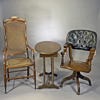

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: There are three chairs. The chair on the left has a high back and is padded. The chair in the middle has a round table. The chair on the right has a high back and a round table.
==> Ground truth answer: This exhibit focuses on a pivotal moment in American history, specifically the surrender of the Confederate Army at Appomattox Court House on April 9, 1865. It showcases the chair used by General Ulysses S. Grant during his negotiations with General Robert E. Lee, marking the effective conclusion of the Civil War. The exhibit highlights how Grant, seated in this chair, drafted and signed the surrender terms, a significant act that symbolized the end of hostilities. Following the surrender, Union officers took pi

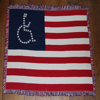

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: On the floor is a blanket with the American flag on it.
==> Ground truth answer: This exhibit features a unique lap blanket that has been hand-altered to incorporate the universal access symbol, represented by stitched stars, reflecting the ideals of freedom and independence associated with the American flag. Created by advocates from the American Disabled for Attendant Programs Today (ADAPT), this piece signifies the ongoing struggle for civil rights among individuals with disabilities. Founded in 1983 in Denver, ADAPT emerged from the disability rights movement, which gained momentum after World War II as individuals with disabilities formed communities and advocated for their rights. The lap blanket serves a

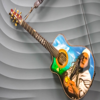

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A guitar is against a wall with the word Vive painted on it.
==> Ground truth answer: This exhibit showcases the guitar of Carlos Vives, a renowned Colombian singer and Grammy Award winner celebrated for his contributions to the vallenato music genre. Vallenato, originating from Colombia's Atlantic coast, blends European instruments like the accordion with rich, poetic lyrics and the traditional rhythms of the Arhuaco indigenous people. Historically, vallenato was performed by rural workers and cowboys, remaining largely within local communities until its revitalization in the 1990s by artists like Vives, who infused it with pop and rock elements. This transformation propelled vallenato into the global spotligh

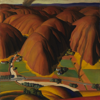

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting. In this image we can see hills, trees, houses, road, grass and sky.
==> Ground truth answer: This exhibition features a captivating painting by Ross Dickinson, a talented artist who thrived during the Great Depression. Created while he was part of the Public Works of Art Project, the artwork vividly portrays California's Central Valley, showcasing lush green fields alongside a small river, all framed by stark, arid hills. The scene evokes the promised land sought by many families fleeing the Dust Bowl, yet Dickinson introduces an unsettling element—a small controlled fire in the foreground and a larger plume of smoke rising from the distant hills, hinting at the ever-present threat of wildfi

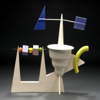

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a sculpture.
==> Ground truth answer: This exhibit features the imaginative work of artist Peter Shire, born in Los Angeles in 1947. Notably, Shire's teapots, particularly the Weathervane Teapot, are vibrant constructions made from clay slabs, showcasing a playful arrangement of three-dimensional squares, balls, squiggly rods, and hollow tubes. Shire aimed to challenge conventional notions of "tea-time," making it an experience that is inclusive and accessible to everyone. The design of this teapot invites interaction, prompting viewers to ponder how to hold it for pouring, or whether it is even functional as a teapot. After 1985, Shire shifted his focus from creating clay teapots to furniture design. A

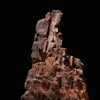

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a wooden object.
==> Ground truth answer: The exhibit features the Spotsylvania tree stump, a poignant relic from the Civil War, dating back to 1864–65, located at the Smithsonian's National Museum of American History. This tree, once a majestic oak, stood in a serene meadow near Spotsylvania Court House, Virginia, until May 12, 1864, when it became a silent witness to the brutal conflict between Confederate forces and the Union's Second Corps. The area, now known as the Bloody Angle, transformed dramatically over the course of a single day, as the fierce combat led to approximately 31,000 casualties. The tree stump bears the scars of war, with several Minié balls still lodged within it

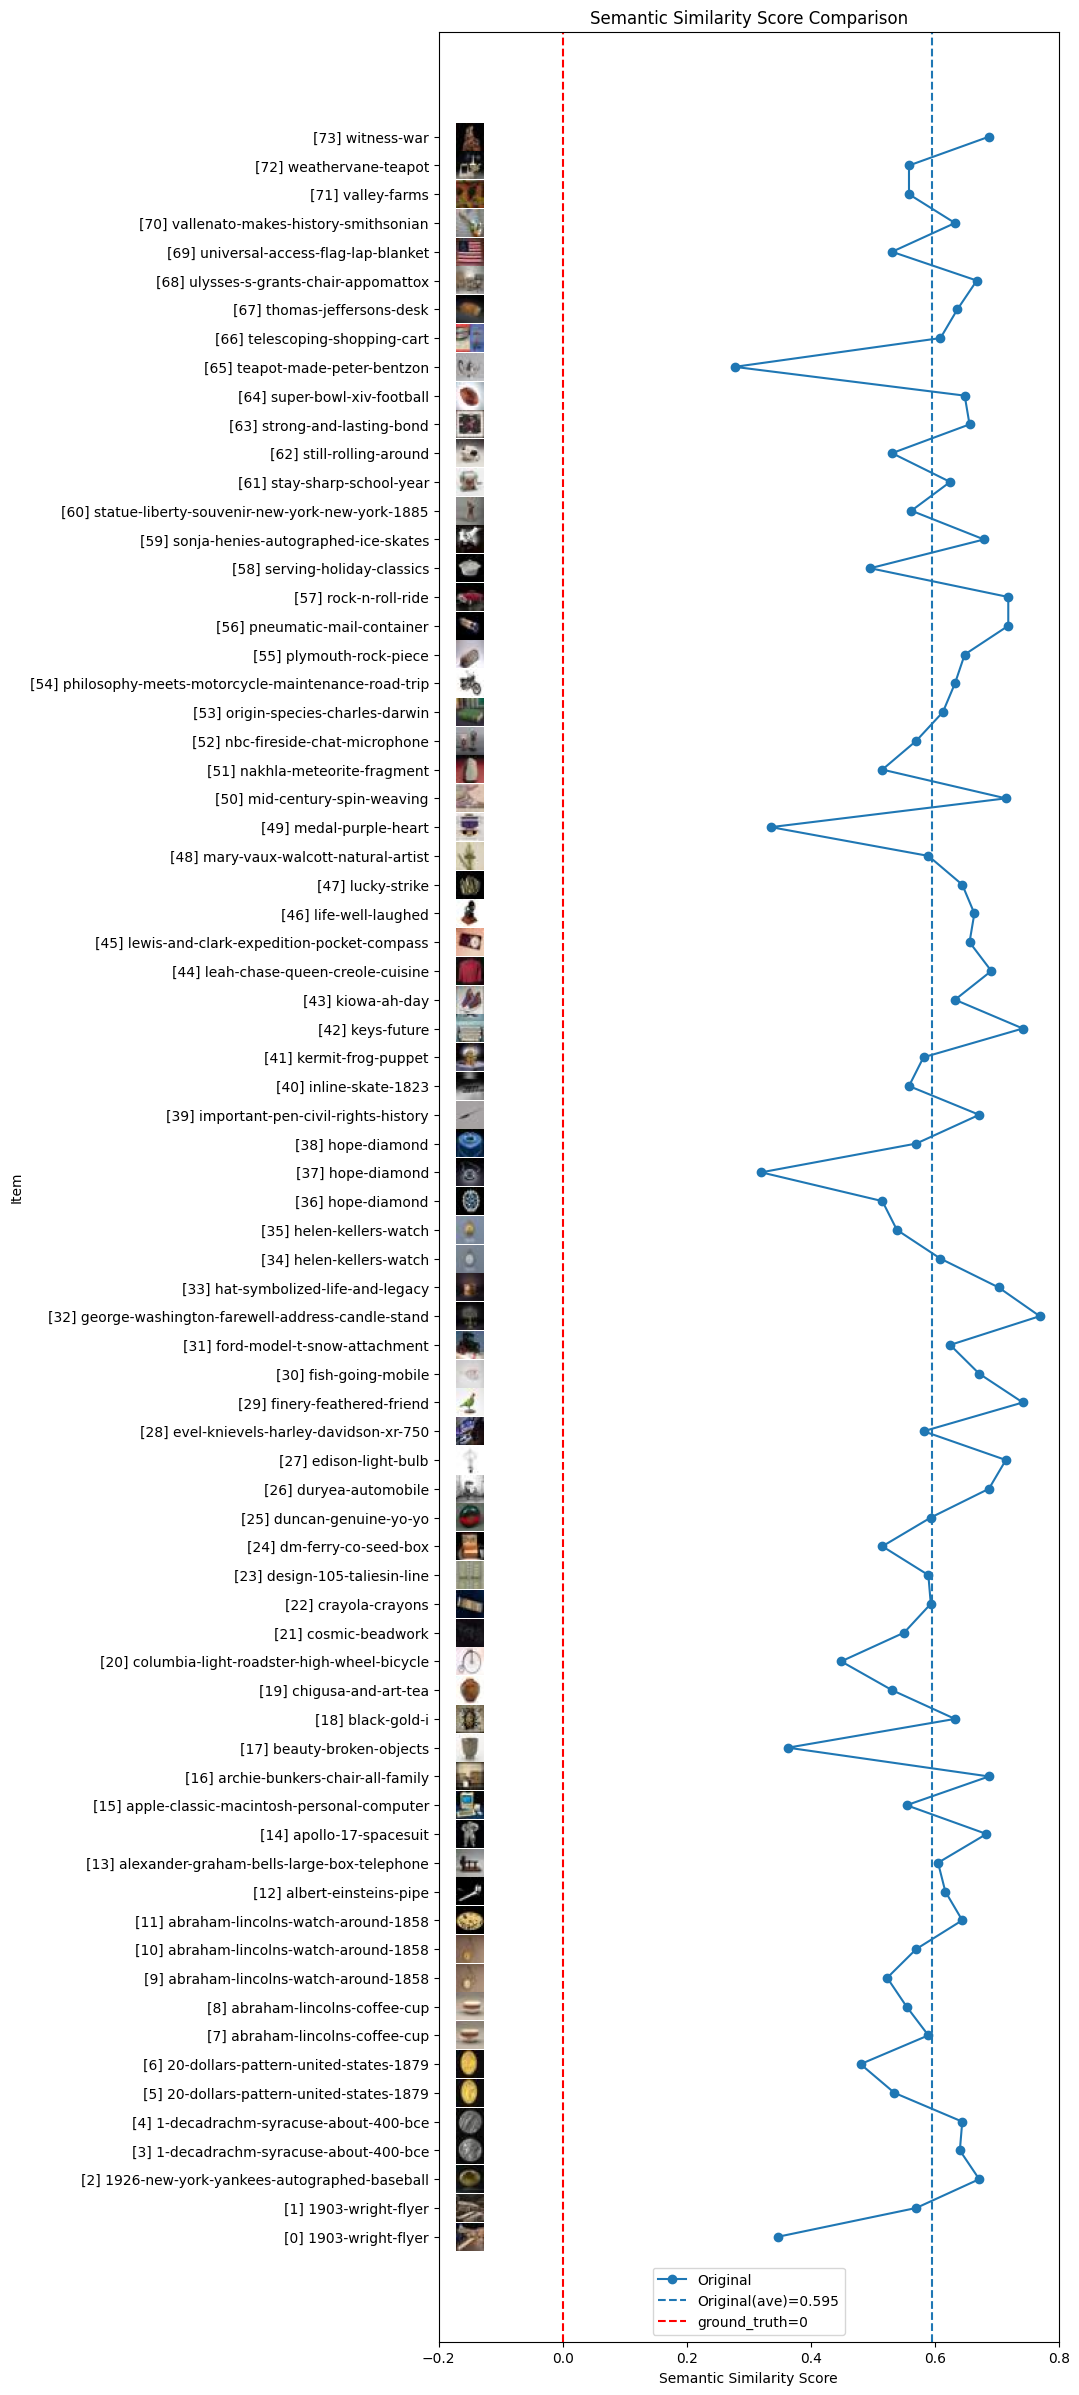

In [4]:
# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(base_model, processor, dataset['test'], './results/inference_results/inference_results_before_finetuning.csv', 10) 
# Plot similarity scores from the inference CSV file, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv')], 
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_before_finetuning.jpg')

---
# **Step 3: Training**

## 3.1 Add a Custom Padding Token

In [5]:
# Set up pad token (<pad>) in the processor
my_utils.setup_pad_token_in_processor(processor)
# Set up pad token (<pad>) in the base model
my_utils.setup_pad_token_in_model(base_model, processor)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.


## 3.2 Select Layers for Full Fine-Tuning

In [6]:
%%writefile my_utils_full_finetuning.py
#--------------- Functions in Full Fine-Tuning ---------------
# 1) Select Layers for Full Fine-Tuning
def select_layers_for_full_fine_tuning(model, module_list):
    print("==> Selecting Layers for Full Fine-Tuning...")
    for name, param in model.named_parameters():
        param.requires_grad = False               # Freeze all parameters by default
        for module in module_list:
            if module in name and 'proj' in name: # Set linear('proj') layers in the specified modules to trainable
                param.requires_grad = True
                break
    return model
    

Writing my_utils_full_finetuning.py


In [7]:
import my_utils_full_finetuning

# Select layers to fine-tune:
# - Freeze the `vision_model` module entirely.
# - Fine-tune linear ('proj') layers in the `text_model` and `connector` modules.
fine_tuning_module_list = ['text_model', 'connector']
full_fine_tuning_model = my_utils_full_finetuning.select_layers_for_full_fine_tuning(base_model, fine_tuning_module_list)
my_utils.print_model_info_to_file(full_fine_tuning_model, './results/model_info/full_finetuning_model_info.txt')
my_utils.print_model_parameters_to_file(full_fine_tuning_model, './results/model_info/full_finetuning_model_parameters.txt')

==> Selecting Layers for Full Fine-Tuning...
==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/full_finetuning_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
model.vision_model.encoder.layers.0.self_attn.k_proj.weight (1327104, torch.bfloat16, cuda, False)
model.vision_model.encoder.layers.0.self_attn.k_proj.bias (1152, torch.bfloat16, cuda, False)
model.vision_model.encoder.layers.0.self_attn.v_proj.weight (1327104, torch.bfloat16, cuda, False)
model.vision_model.encoder.layers.0.self_attn.v_proj.bias (11

## 3.3 Set Up the Trainer

In [8]:
custom_callback = my_utils.CustomCallback()  # Optional: Custom callback to report VRAM usage during the first training step
trainer = my_utils.setup_trainer(full_fine_tuning_model, processor, dataset, my_utils.collate_fn, epoch_num=3, batch_size=10, callbacks=[custom_callback])

Using auto half precision backend


==> Setting up trainer...


## 3.4 Train the Model

In [9]:
my_utils.run_training(full_fine_tuning_model, trainer)

==> Starting training...


Currently training with a batch size of: 10
***** Running training *****
  Num examples = 819
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 246
  Number of trainable parameters = 7,722,237,952
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


[GPU0] Step 1: Current VRAM usage: 44.64 GB, Peak VRAM usage: 73.48 GB, Total GPU VRAM: 79.25 GB



***** Running Evaluation *****
  Num examples = 82
  Batch size = 10
Saving model checkpoint to ./results/training_checkpoints/checkpoint-13
perciver_config is None, using default perceiver config
vision_config is None, using default vision config
text_config is None, using default text config
perciver_config is None, using default perceiver config
vision_config is None, using default vision config
text_config is None, using default text config
Configuration saved in ./results/training_checkpoints/checkpoint-13/config.json
Configuration saved in ./results/training_checkpoints/checkpoint-13/generation_config.json
The model is bigger than the maximum size per checkpoint (5GB) and is going to be split in 4 checkpoint shards. You can find where each parameters has been saved in the index located at ./results/training_checkpoints/checkpoint-13/model.safetensors.index.json.
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_gr

---
# **Step 4: Post-Training**

## 4.1 Restart Kernel for a Clean Environment

## 4.2 Load the Fine-Tuned Model from a Checkpoint  

After training, we load the fine-tuned model using the checkpoint with the minimum loss. This fine-tuned model will be used for further inference to assess improvements in model performance.


In [1]:
# Load functions
import my_login
import my_utils

# Log in to the Hugging Face and Weights & Biases accounts
my_login.login_hf()
my_login.login_wandb()

# Load processor and base model
processor = my_utils.load_processor()
full_fine_tuning_model = my_utils.load_model(model_path='./results/training_checkpoints/checkpoint-156')

# Set up pad token (<pad>) in the processor and in the base model
my_utils.setup_pad_token_in_processor(processor)
my_utils.setup_pad_token_in_model(full_fine_tuning_model, processor)


==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


==> Loading processor...


Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


==> Loading model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...
==> No resizing needed for token embeddings.


## 4.3 Perform Inference with the Fine-Tuned Model

==> Loading hf dataset...
==> Performing batch inference and saving results to ./results/inference_results/inference_results_after_finetuning.csv ...
==> [Batch: 1/8] Data in batch: 10
==> [Batch: 1/8][Data: 1/10] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


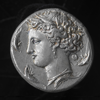

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, a stunning coin from the late 5th century BCE, renowned for its exquisite artistry and high relief, designed by notable figures such as Kimon and Euinatos. This piece has captivated collectors for over two millennia with its intricate details and elevated relief, showcasing the skill of ancient Greek artisans. Notably, this coin was a favorite of Theodore Roosevelt, a forward-thinking American president known for his reformative policies. He criticized the lack of artistry in contemporary American coins compared to classical masterpieces like the dekadrachm and sought to create a more aesthetically pleasing currency. His initiative led to a partnership with sculpto

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


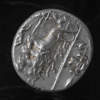

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, a stunning coin from the late 5th century BCE, renowned for its exquisite artistry and high relief, designed by notable figures like Kimon and Euinatos. This piece has captivated collectors for over two millennia with its intricate details and elevated relief, showcasing the skill of ancient Greek artisans. Notably, this coin was a favorite of Theodore Roosevelt, a forward-thinking American president known for his reformative policies. He criticized the lack of artistry in contemporary American coins compared to classical masterpieces like the dekadrachm and sought to create a more aesthetically pleasing currency. His initiative led to a partner

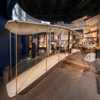

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the Smithsonian's National Air and Space Museum features the 1903 Wright Flyer, the first successful powered aircraft to carry a pilot. Constructed by aviation pioneers Wilbur and Orville Wright, this biplane is powered by a 12-horsepower engine and utilizes a sprocket-and-chain system to turn its pusher propellers. The Flyer made its historic first flight on December 17, 1903, at Kitty Hawk, North Carolina, achieving a 36-meter journey in just 12 seconds with Orville at the controls. The Wright brothers' extensive research over four years not only led to this remarkable flight but also established key principles of modern aeronautical engineering, including the use of wind tunnels in design tes

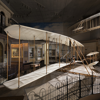

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1903 Wright Flyer, the first successful powered aircraft to carry a pilot, developed by aviation pioneers Wilbur and Orville Wright. The Flyer is powered by a 12-horsepower engine and utilizes a sprocket-and-chain system to turn its pusher propellers. Its historic first flight took place on December 17, 1903, at Kitty Hawk, North Carolina, where it achieved a 36-meter journey in just 12 seconds with Orville at the controls. The Wright brothers' extensive research over four years not only led to this remarkable flight but also established key principles of modern aeronautical engineering, including the use of wind tunnels in design testing. The Flyer is currently par

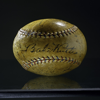

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an autographed baseball from the 1926 New York Yankees, prominently signed by Babe Ruth and Lou Gehrig, both of whom are celebrated figures in baseball history. Ruth, known for his remarkable batting skills, and Gehrig, who achieved an impressive record of 2,130 consecutive games, represent the pinnacle of professional athletics. Gehrig's diagnosis with amyotrophic lateral sclerosis (ALS), often called Lou Gehrig's disease, highlighted his extraordinary bravery and humility, inspiring many. The baseball itself is composed of cork, wool, and horsehide, with an overall diameter of 3 inches. Although it is not currently on display, this artifact is part of the National Museum of American Hist

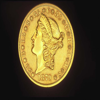

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold coin minted by the United States Mint in Philadelphia, notable for its distinctive design and historical context. The obverse displays a Liberty head facing left, with the date placed below and inscriptions regarding weight and fineness surrounding it. The reverse showcases an eagle, but notably replaces the traditional saying "IN GOD WE TRUST" with "DEO EST GLORIA." This design was inspired by a broader initiative to enhance the international competitiveness of American coins, which also led to the introduction of the four-dollar gold Stella coin. Among the nine known gold pieces of this design, the one in question dates back to 1879 and has a catalog number of 1994.0371

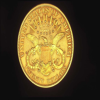

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold coin minted by the United States Mint in Philadelphia, showcasing a unique design with Liberty's head on the obverse and an eagle, emblazoned with the Latin motto "DEO EST GLORIA," on the reverse. This coin was part of a movement to enhance the international competitiveness of American coinage, alongside the introduction of the four-dollar gold Stella coin. Only nine of these coins are known to exist, including this one, which is currently not on display. The record for this coin was last updated on September 26, 2022, and it is cataloged with the ID number 1994.0371.0001. For more information, please visit the National Museum of American History's web

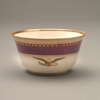

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact: Abraham Lincoln's coffee cup, which dates back to 1887 and was gifted to the Smithsonian by Lincoln Isham, the great-grandson of President Lincoln. The cup has a compelling story; on April 14, 1865, just before heading to Ford's Theatre for the last time, Lincoln inadvertently left this cup on a windowsill, where it was later preserved by a White House servant. Captain D.W. Taylor later presented the cup to Robert Todd Lincoln, who kept it as a family heirloom. The cup is crafted from ceramic and features a striking design in purple with white and gold trim, measuring approximately 3 1/4 inches in height. It is currently displayed in the National Museum of American 

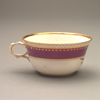

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant piece of American history: Abraham Lincoln's coffee cup, which dates back to 1887 and was gifted to the Smithsonian by Lincoln Isham, the great-grandson of President Lincoln. The cup has a compelling story; on April 14, 1865, just before heading to Ford's Theatre for the last time, Lincoln inadvertently left this cup on a windowsill, where it was later preserved by a White House servant. In 1880, Captain D.W. Taylor gifted the cup to Robert Todd Lincoln, who cherished it as a family heirloom. The cup is crafted from ceramic and features a striking design in purple with white and gold trim, standing approximately 3 1/4 inches tall. It is currently displayed

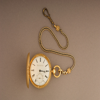

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary artifact: Abraham Lincoln's gold pocket watch, which he acquired in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a testament to his success in his legal career. The movement was manufactured in Liverpool, a renowned watchmaking city, while the case was crafted in the United States by an unknown maker. The watch is notable for its top-quality movement, which can keep time with remarkable accuracy when properly maintained. Its 18K gold case is of the highest standard, showcasing exceptional craftsmanship. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonathan Dillon du

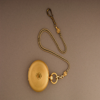

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary artifact: Abraham Lincoln's gold pocket watch, which he acquired in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a testament to his success in his legal career. The movement was manufactured in Liverpool, a renowned watchmaking city, while the case was crafted in the United States by an unknown maker. The watch is notable for its top-quality movement, which can keep time with remarkable accuracy when properly maintained. Its 18K gold case is of the highest standard, showcasing exceptional craftsmanship. A fascinating aspect of this watch is the hidden message engraved by watchmake

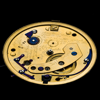

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this exquisite gold watch served as a testament to his success in his legal career. The watch's movement, crafted in Liverpool—a center for watch manufacturing—boasts one of the finest grades available, capable of accurate timekeeping within seconds daily. The case, made in the United States, is 18K gold, showcasing exceptional quality. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonathan Dillon during repairs on April 12, 1861, 

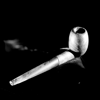

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an iconic piece of history: Albert Einstein's pipe, dating back to approximately 1948. Renowned for his groundbreaking contributions to theoretical physics and his Nobel Prize, Einstein is also recognized for his distinctive appearance, which prominently included a pipe. Although he reduced his smoking later in life for health reasons, he never let go of the tactile pleasure associated with it. This particular pipe bears the marks of his long-term use, evident in the hole worn into its bit. Einstein gifted this pipe to his devoted friend, Gina Plunguian, after which it was acquired by the Smithsonian in 1979. It is part of a larger collection of over 1,000 artifacts displayed at various Sm

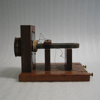

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History focuses on the groundbreaking invention of the telephone by Alexander Graham Bell, who received the first patent for this device on March 7, 1876. Just days later, Bell successfully communicated with his assistant, Thomas Watson, marking a pivotal moment in communication history. Among the items on display is one of the two telephones used during a demonstration between Boston and Salem on November 26, 1876. This particular telephone is notable for its design, which includes an iron diaphragm and two electromagnets, and it is noteworthy for being one of the earliest telephones produced in the United States. The Smithsonian acquired this significant artifac

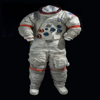

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apollo 17 spacesuit, an iconic artifact from the final Apollo mission that landed on the moon in December 1972. The mission was launched on December 7, 1972, using a Saturn V rocket and included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, who was the first geologist to walk on the moon. While Evans orbited the moon, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region, where they conducted three moonwalks over three days, collected 110 kilograms of lunar samples, and drove a lunar rover for 35 kilometers. Cernan's spacesuit, which weighed about 185 pounds when fully equipped, is notable for being the 

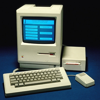

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apple "Classic" Macintosh Personal Computer, which made its debut in January 1984. Apple Inc. introduced a revolutionary graphic user interface that allowed users to interact with their computers using visual icons instead of traditional command lines. This innovation was inspired by concepts from Xerox's Palo Alto Research Center but was successfully commercialized by Apple, which famously promoted the Macintosh with a Super Bowl XVIII advertisement, pricing it around $2,500. The original Macintosh was equipped with just 128K of RAM, prompting the release of the Macintosh 512 KB, or "Fat Mac," in September 1984, which quadrupled memory capacity and enabled better multitasking. This mo

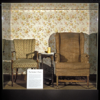

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the original wing chair used by Archie Bunker, played by Carroll O'Connor, in the landmark television series All in the Family. Upholstered in a vibrant orange-yellow woven fabric, the chair is supported by a wooden frame with arms and legs, and is believed to have been made in the 1940s, although the exact maker and date are unknown. It was acquired from a thrift store in Southern California and became a key prop in the show until a reproduction was created for the final season after its donation to the Smithsonian. All in the Family, which aired from 1971 to 1979, was a pioneering sitcom that tackled complex social and political issues, reflecting the changing dynamics of American societ

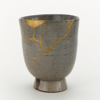

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning tea bowl from the 17th century, belonging to the White Satsuma style, originating from Kagoshima prefecture in Japan. The bowl, crafted from stoneware and adorned with a clear crackled glaze, showcases the artistry of kintsugi, a revered Japanese repair technique that highlights rather than conceals damage. After experiencing breakage, the bowl was restored with lacquer made from tree sap, which is toxic in its liquid form but transforms into a safe and durable material upon curing. This process not only ensures the bowl remains functional but also enhances its aesthetic appeal with golden reinforcements in the cracks. Kintsugi has been utilized in Asian ceramics for centuries, 

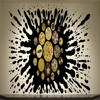

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the innovative work of Yinka Shonibare, a distinguished artist born in London in 1962. It includes a striking collection of 25 circular canvases, each varying in size and arranged against a large-scale ink splatter pattern, applied with a template. The canvases are adorned with intricate foliate patterns painted in black and gold, utilizing Dutch wax printed fabrics. Shonibare's artistic journey is marked by a transition from his earlier grid-based compositions to these contemporary pieces, which challenge conventional edges and borders. The work references "black gold," a term for Africa's oil resources, and engages in a playful dialogue with the techniques of Jackson Pollock. This exhibi

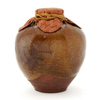

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a captivating tea-leaf storage jar from the 17th century, belonging to the White Satsuma style of Kagoshima prefecture, Japan. The jar, adorned with an elegant orange-yellow glaze, showcases the artistry of kintsugi, a revered Japanese repair technique that highlights rather than conceals damage. After experiencing wear and tear, the jar was restored with lacquer made from tree sap, which is toxic in its liquid form but transforms into a safe and durable material upon curing. This process not only ensures the jar remains functional but also enhances its aesthetic appeal with a distinctive golden sheen. Kintsugi has been utilized in Asian ceramics for centuries, but its decorative applicati

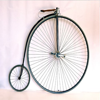

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History features an original 1886 Columbia Light Roadster high-wheel bicycle, celebrating the arrival of spring. Manufactured by the Pope Manufacturing Co., the first bicycle maker in the United States, this bicycle was initially priced at about $135 and showcases a 53-inch front wheel with 60 spokes and an 18-inch rear wheel with 20 spokes. Additionally, a historic photograph from 1879 accompanies the bicycle, depicting one of the earliest organized biking tours in America, led by Charles E. Pratt, the first president of the League of American Wheelmen. The Smithsonian's cycling collection, established in 1889, includes 60 bicycles that highlight the technologica

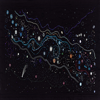

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the captivating work of Margaret Nazon, a Gwich'in artist from Tsiigehtchic, Northwest Territories, Canada, created in 2021. Nazon, who began exploring her childhood fascination with the stars later in life, was inspired after seeing images from the Hubble Space Telescope. This artwork, characterized by swirling galaxies, represents a departure from traditional Gwich'in beadwork, showcasing Nazon's unique artistic voice. It is part of the "Lights Out: Recovering Our Night Sky" exhibition at the Smithsonian's National Museum of Natural History, which highlights the detrimental effects of light pollution on the night sky and its broader implications for ecosystems and cultures worldwide. The 

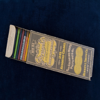

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a historic pack of Crayola Crayons, dating back to 1903, that symbolizes the creativity of children throughout generations. Invented by cousins Edwin Binney and C. Harold Smith, the crayons were produced by their Binney & Smith Company in Easton, Pennsylvania. Constructed from paraffin wax and non-toxic pigments, these crayons were designed to be safe, durable, and inexpensive. The name "Crayola," created by Alice Binney, combines the French word for chalk, "craie," with "oleaginous," emphasizing the crayons' waxy texture. This particular set, aimed at young artists, is one of the earliest produced and includes 28 colors, such as celestial blue and rose pink. The box, marked "No. 51, Young

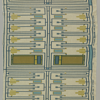

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a striking textile designed by the renowned American architect Frank Lloyd Wright, who lived from 1867 to 1959. The piece, produced by F. Schumacher & Co., a prominent New York manufacturer established in 1889, showcases a geometric design characterized by rectangular blocks in light blue and varying shades of olive, along with fine lines of darker blue on an off-white background. The dimensions of this printed linen are 120 cm in height and 57.5 cm in width (47 1/4 in. by 22 5/8 in.), with a repeat height of 63.5 cm (25 in.). Additionally, the upper back of the textile features samples of five alternative colorways. This artwork is currently under research for cataloging and was generousl

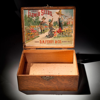

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an antique seed box from the 1890s, showcasing a piece of history from D.M. Ferry & Co., a prominent seed company based in Detroit. The box, made of wood and measuring 10 by 12 by 5 inches, is adorned with an eye-catching label that illustrates the company's role in the flower seed industry. As part of the Smithsonian's first major exhibition on gardening, this seed box serves as a historical artifact that reflects the marketing strategies of the time. The Smithsonian's extensive collection includes over 10,000 seed trade catalogs, which can be explored further on the Smithsonian Institution Libraries website.
==> Ground truth answer: This exhibit features an antique seed box from the late

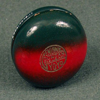

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the Smithsonian's National Museum of American History highlights the intriguing history of the yo-yo, a toy that gained immense popularity in America, largely due to the efforts of Donald F. Duncan Sr., a businessman from Chicago. The story begins in 1928 when Duncan discovered the yo-yo during a business trip to San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant who had begun marketing the toy, which translates to "come-come" in Filipino. By early 1929, Flores had established his own company and produced over 100,000 wooden yo-yos, understanding the need for demonstrations to drive sales. Duncan, recognizing the toy's potential, invested $5,000 to acquire rights from F

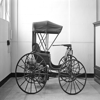

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1893-94 Duryea automobile, a landmark vehicle in the history of American transportation. Frank Duryea conducted its historic road test in Springfield, Massachusetts, on September 21, 1893, adapting a second-hand carriage with a gasoline engine. The Duryea Motor Wagon Company, founded in 1896 by Frank, his brother Charles, and their financial supporters, was the first American enterprise to manufacture and sell automobiles. The vehicle is equipped with a one-cylinder, four-cycle, four-horsepower water-cooled gasoline engine, positioned almost horizontally beneath the body, and features a gear transmission, which replaced the original friction system, as well as a spray carburetor and ma

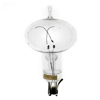

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Edison Light Bulb, a landmark invention from 1879 by Thomas Edison, renowned as a key figure in American innovation. This carbon-filament bulb was pivotal in demonstrating the feasibility of the electric incandescent lamp, which was first showcased to the public during a demonstration at Edison's Menlo Park laboratory on New Year's Eve. The bulb operates by allowing an electrical current to flow through a metal filament, which heats up and produces light. To protect the filament from air exposure, it is enclosed in a glass bulb filled with inert gas. Edison's contributions extend beyond this invention; he is celebrated for holding a remarkable 1,093 patents and is recognized as a quint

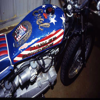

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Evel Knievel's iconic 1972 Harley-Davidson XR-750, a symbol of thrilling American entertainment. Evel Knievel, born Robert Craig Knievel, was a daredevil known for his audacious motorcycle stunts, which gained national attention beginning in 1965. His performances, which included jumping over rows of vehicles, made him a household name and showcased the height of motorcycle stunt artistry. This particular motorcycle, crafted from steel, aluminum, and fiberglass, weighs about 300 pounds and was instrumental in some of his most impressive jumps, including a record leap over 14 Greyhound buses in 1975. Knievel's career was marked by 35 to 40 broken bones, a testament to the inherent risks of 

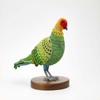

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features Laurel Roth Hope's intriguing work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece employs humor to confront the grave issue of species extinction, allowing common rock pigeons to don suits that enable them to mimic extinct North American birds. While it doesn't restore biodiversity, it certainly plays with the notion in a visually captivating way. Hope's artistic process involves traditional techniques such as carving, embroidery, crochet, and collage, which she uses to craft detailed animal sculptures that are both whimsical and thought-provoking. Drawing from her background as a park ranger, she b

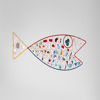

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features “Fish,” a striking sculpture by Alexander Calder, created in 1945 and part of the Hirshhorn Museum and Sculpture Garden's collection in Washington, D.C. Calder, who hailed from a family of artists, initially earned a degree in mechanical engineering before dedicating himself to art. His artistic journey took him from freelancing as an illustrator in New York to the vibrant art scene of Paris, where he developed his innovative wire sculptures that critics hailed as “drawings in space.” Inspired by the simplicity of Piet Mondrian's studio, Calder invented the “mobile,” a form of kinetic sculpture, in 1931. He also conceived “stabiles,” which are static sculptures, as well as standing mobiles 

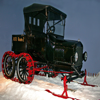

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a 1921 Ford Model T equipped with a snow attachment, illustrating the evolution of rural mail delivery methods in snowy conditions. In the early 20th century, rural mail carriers faced challenges as their vehicles struggled to traverse snowy landscapes. To adapt, Virgil White pioneered a solution by converting automobiles into snowmobiles, replacing front tires with skis and outfitting the rear with caterpillar treads through his invention known as the Snowbird. This innovation allowed carriers to eliminate the need for horses and sleds during winter months. The Ford Model T quickly became the favored vehicle for such modifications, and by 1922, White's kits were priced between $250 and $4

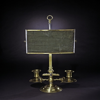

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact: a brass candle stand that is closely tied to George Washington's legacy. After two successful terms as president, Washington chose to retire to Mount Vernon, where he delivered his Farewell Address in September 1796. This address, published in The American Daily Advertiser, served as his final piece of guidance to the nation, urging Americans to prioritize unity over political divisions. The candle stand, which showcases an adjustable reflector lined with green silk to enhance candlelight, is believed to have been used by Washington during this pivotal moment. It was passed down through the Lewis family, descendants of Washington's relatives, and sold to the U.S. go

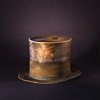

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the top hat of President Abraham Lincoln, displayed at the Smithsonian's National Museum of American History. Standing at 6'4”, Lincoln was not only distinguished by his height but also by his choice of fashion, specifically his high top hats. This particular hat was crafted by Washington hat maker J.Y. Davis and includes a black silk mourning band, a tribute to his son Willie, who died in 1862. While the exact date of acquisition and the frequency of its use remain uncertain, it is known that Lincoln last wore this hat on the evening of April 14, 1865, before heading to Ford's Theatre. Following his assassination, the War Department preserved the hat along with other personal items, and i

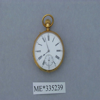

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this exquisite gold watch served as a testament to his success in his legal career. The movement, crafted in Liverpool—a center for watch manufacturing—boasts one of the finest grades available, capable of accurate timekeeping within seconds daily. The case, made in the United States, is 18K gold, showcasing exceptional quality. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonathan Dillon during repairs on April 12, 1861, coinciding with the onset of the Civil War. Dillon's engraving, al

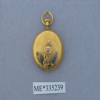

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable artifact: Abraham Lincoln's gold pocket watch, which he purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not one to show off, this watch served as a testament to his success in his legal career. The movement was manufactured in Liverpool, a renowned watchmaking city, while the case was crafted in the United States by an unknown maker. The watch is notable for its top-quality movement, which can keep time with remarkable accuracy when properly maintained. Its 18K gold case is of the highest standard, showcasing exceptional craftsmanship. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonath

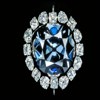

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a single primary gem weighing 45.52 carats. The diamond is distinguished by its dark gray-blue color and is cut into a modified antique cushion shape, which enhances its unique visual appeal. This exquisite piece was sourced from India, further emphasizing its luxurious origins. It is categorized under the Mineral Sciences department, specifically within the Gems collection, and is recorded with the USNM Number NMNH G3551-00. This necklace is a significant artifact for those interested in the artistry and geological significance of gemstones.
==> Ground truth answer: This exhibit features a stunning diamond necklace crafted by Cartie

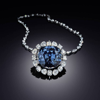

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a single primary gem weighing 45.52 carats. The diamond, with its dark gray-blue color, is cut into a modified antique cushion shape, which enhances its unique visual appeal. This exquisite piece was sourced from India, further emphasizing its luxurious origins. The necklace is categorized under the Mineral Sciences department, specifically within the Gems collection, and is recorded with the USNM Number NMNH G3551-00. This artifact is currently not on display, but it serves as a significant example of the beauty and rarity of gemstones.
==> Ground truth answer: This exhibit showcases a remarkable diamond necklace

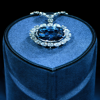

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a single primary gem weighing 45.52 carats. The diamond, with its dark gray-blue color, is cut into a modified antique cushion shape, enhancing its unique visual appeal. This exquisite piece was sourced from India, further emphasizing its luxurious origins. It is categorized under the Mineral Sciences department, specifically within the Gems collection, and is recorded with the USNM Number NMNH G3551-00. This necklace is a significant artifact for those interested in the artistry and geological significance of gemstones.
==> Ground truth answer: On display is a captivating diamond

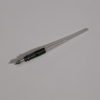

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an Esterbrook pen that holds historical significance as the instrument with which President Lyndon B. Johnson signed the Civil Rights Act of 1964 on July 2, 1964. This pen, along with over 70 identical ones, was given to key figures in the Civil Rights Movement as a symbol of recognition. The path to this landmark legislation was complex, initially introduced by President John F. Kennedy before his tragic assassination in November 1963. President Johnson's leadership was crucial in overcoming significant resistance, including a record-setting 57-day filibuster in the Senate. The Civil Rights Act represented a foundational step toward achieving equality, requiring ongoing efforts and additi

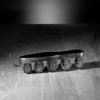

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Volito, an inline skate dating back to 1823, which illustrates the evolution of skate technology prior to the establishment of indoor rinks. The skate is characterized by its wooden sole and a single row of five wooden wheels, complemented by a curved iron bar at the front that functions as a basic brake. Notably, the Volito's wheels vary in size, with larger centers facilitating smoother turns compared to traditional skates of the time. This design innovation allowed skaters to navigate turns more effectively, making the Volito a significant artifact in the history of roller skating. Although it is currently not on display, the skate is part of the National Museum of American History'

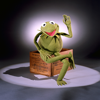

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Kermit the Frog, a character created by Jim Henson that has become synonymous with children's entertainment. Kermit first graced screens in 1955 on the television program "Sam and Friends" and later became the beloved host of "The Muppet Show." He is known for his calm and rational nature amidst the chaos of his surroundings, famously singing the song “Bein' Green,” which reflects on the challenges of his green color while ultimately celebrating his identity. The exhibit includes Kermit's original puppet, crafted from materials like synthetic fiber and felt, and measures 27 inches in height. This artifact is part of the "Entertainment Nation" exhibition at the National Museum of American H

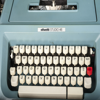

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the typewriter of Octavia Butler, a pioneering science fiction author who passed away in 2006. Butler is celebrated for her groundbreaking works, including the Patternist series and the Xenogenesis trilogy, and her literature is characterized by a rich blend of African American history, speculative futures, and explorations of alien psychology, which collectively define the genre of Afrofuturism. Her early novels, such as Wild Seed and Kindred, prominently featured characters of the African diaspora, inviting readers to envision themselves as innovators and heroes in speculative futures. Throughout her career, Butler received numerous accolades, including the Nebula and

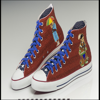

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a striking pair of sneakers designed by Kiowa artist Teri Greeves, born in 1970. The sneakers, crafted in 2004, are made from cotton canvas and adorned with intricate overlay beadwork, showcasing a blend of modern and traditional artistry. With dimensions of 33 x 11 x 15 cm, this work exemplifies the evolution of Native American art forms while remaining rooted in cultural heritage. The National Museum of the American Indian acquired this piece from Thirteen Moons Gallery in Santa Fe, New Mexico, in 2004, where it is currently part of the exhibition “Kiowa Ah-Day.” This exhibit not only highlights the artistic skill of Greeves but also reflects the ongoing dialogue between indigenous cultu

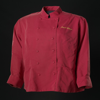

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a compelling collection from the Smithsonian's National Museum of African American History and Culture, generously donated by Dooky Chase's Restaurant and the esteemed Chef Leah Chase. Known as “The Queen of Creole Cuisine,” Chase's restaurant became a pivotal meeting place for civil rights leaders, where they would strategize over her delicious gumbo. The exhibit showcases her impact on American gastronomy and civil rights, encapsulated in her signature red chef's jacket, which is now part of the museum's collection. Visitors can also view her portrait on the Smithsonian's National Portrait Gallery website.
==> Ground truth answer: This exhibit showcases a significant collection from the 

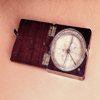

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket compass that dates back to approximately 1804, associated with the Lewis and Clark Expedition. Meriwether Lewis acquired this compass from Philadelphia instrument maker Thomas Whitney as he prepared for the expedition directed by President Jefferson. The compass is finely crafted with a silver-plated brass rim marked with degrees, a paper dial, and two brass sight vanes, all enclosed in a mahogany box with a leather carrying case. Its specific purpose—whether Lewis intended it for his own use or as a gift for William Clark—remains a mystery. The Corps of Discovery, under Lewis and Clark's leadership, embarked on their expedition in May 1804 to explore the northwestern t

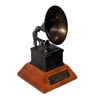

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1960 Grammy Award of Bob Newhart, a celebrated comedian and actor whose career spans over six decades. Born on September 5, 1929, in Oak Park, Illinois, Newhart is known for his deadpan humor that critiques various aspects of American culture. His debut album, The Button-Down Mind of Bob Newhart, was groundbreaking, being the first comedy LP to top the Billboard charts and winning him a Grammy for Album of the Year, along with the distinction of being the only comedian to win a Grammy for Best New Artist. Newhart's television legacy includes starring roles in iconic sitcoms like The Bob Newhart Show and Newhart, which have left a lasting impact on the genre. His career continued to flo

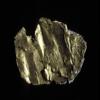

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant gold nugget from 1848, housed in the Smithsonian's National Museum of American History. This nugget is recognized as the first piece of gold discovered at Sutter's Mill in California, an event that triggered the gold rush. The discovery took place on January 24, 1848, when James Marshall, while overseeing the construction of a sawmill, noticed a shiny object in the water. Upon inspection, he identified it as a thin scale of pure gold. Marshall later presented this nugget to Capt. Joseph L. Folsom, who documented it as Specimen No. 1, marking it as the first gold found in Northern California. By August 1848, this nugget was sent to Washington, D.C., where it was presented to P

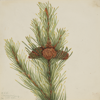

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the watercolor "Lodgepole Pine (Pinus Contorta murrayana)" by Mary Vaux Walcott, created in 1921 and measuring 10 x 7 inches. This piece is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration began when a botanist requested her to depict a rare arnica flower. After marrying Charles Doolittle Walcott in 1914, they spent summers in the Canadian Rockies, where she produced numerous watercolor studies of local flora. Between 1925 and 1929, her work was published in a five-volume series titled "North American Wild Flowers," and she later illustrated "North American Pitcher Plants" in 1935. Walcott's contributions 

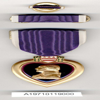

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the esteemed United States Purple Heart, a heart-shaped medal that symbolizes military valor. The medal is crafted from a blend of copper alloy, gold plating, and enamel, showcasing a striking profile relief of George Washington at its center. Above the bust is a shield that represents Washington's family coat of arms. The reverse side is inscribed with the phrase "FOR MILITARY MERIT," honoring those who have displayed exceptional bravery. The medal is attached to a silk ribbon that is purple with a white edge stripe. With dimensions of 3.7 cm by 1.1 cm by 8.1 cm (approximately 1 7/16 by 7/16 by 3 3/16 inches), this piece is made from a combination of materials including copper alloy, silk

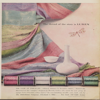

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features a striking advertisement from the 1950s, showcasing the work of Dorothy Liebes (1897–1972), an influential American textile designer. Liebes is celebrated for her vibrant color palettes and rich textures, which played a significant role in shaping mid-20th century design aesthetics. Throughout her career, spanning from the 1930s to the 1960s, she collaborated with notable architects and designers, including Frank Lloyd Wright and Donald Deskey, as well as fashion luminaries like Adrian and Bonnie Cashin. Her fabrics, characterized by bold colors and a metallic sheen, became synonymous with modern American style. Although she enjoyed considerable acclaim during her lifetime, the full extent 

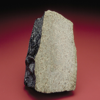

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Nakhla Meteorite Fragment at the Smithsonian's National Museum of Natural History, a remarkable specimen among the thirty-four meteorites known to have come from Mars. The Nakhla meteorite fell to Earth on June 28, 1911, in the Nakhla region of Alexandria, Egypt, where it was observed exploding in the atmosphere before breaking into approximately forty pieces, collectively weighing 22 pounds and burying themselves up to a meter deep. The Smithsonian acquired two samples shortly after the fall, and in 1962, it added a significant 480-gram fragment, bringing the total collection to 650 grams by the 1970s. The Nakhlites, named after Nakhla, are igneous rocks rich in augite and formed from

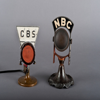

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an RCA Type 50-A microphone, a key artifact from the era of President Franklin D. Roosevelt's "Fireside Chats." Beginning on March 12, 1933, Roosevelt utilized this innovative form of radio communication to speak directly to the American people, fostering a sense of unity and reassurance during the Great Depression. As the nation grappled with economic turmoil, including rampant unemployment and a collapsing banking system, Roosevelt's ability to communicate effectively became a vital tool in navigating the crisis. The first chat took place in the Lincoln Study, with subsequent broadcasts held in the Diplomatic Reception Room of the White House. This particular microphone, which showcases 

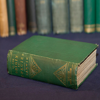

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the groundbreaking work "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the anniversary of the HMS Beagle's launch on May 11, 1820, a ship that played a crucial role in Darwin's scientific exploration. The Beagle was launched from Woolwich Dockyard in London and underwent several modifications before embarking on its second survey voyage on December 27, 1831, where Darwin served as a naturalist. During this five-year expedition to South America and the Galápagos Islands, he collected fossils, studied plant specimens, and analyzed geological formations, which led to his development of the theor

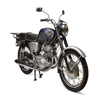

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Robert M. Pirsig's 1966 Honda Super Hawk motorcycle, a key artifact from his influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values," published in 1974. The book sold over a million copies in its first year and initiated a global dialogue about the relationship between humans and technology, positioning Pirsig as a pioneer in the field of human-technology interaction. The narrative is inspired by Pirsig's memorable 1968 road trip with his son Chris, during which they traveled 5,700 miles from Minnesota to San Francisco, deepening their bond and understanding of the world around them. Pirsig's insights into the human experience have sold over 5 million copies a

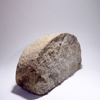

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Plymouth Rock Piece, an iconic artifact from 1620, located at the National Museum of American History. Traditionally recognized as the landing site of the Mayflower Pilgrims, Plymouth Rock is closely associated with William Bradford, a key figure among the settlers and the first governor of Plymouth Colony. He is often credited with the establishment of Thanksgiving in American culture. The rock itself has a storied past; in 1774, it was moved from its original shore location to the town square, where it split into two halves. The bottom half remained in its original spot, while the top half was taken to the meeting house. In 1880, both halves were reunited, although several pieces had

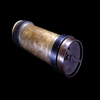

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Pneumatic Mail Container from 1953, housed at the Smithsonian's National Postal Museum. In the late 19th century, cities began implementing pneumatic tube systems beneath their streets to facilitate mail delivery. These canisters, known as carriers, were capable of holding up to 500 letters and were propelled through the tubes by compressed air, reaching speeds of around 35 miles per hour in a spinning motion. At its peak, the system efficiently transported 6 million pieces of mail daily, with five carriers dispatched every minute. The first pneumatic tubes debuted in Philadelphia in 1893, followed by a launch in New York City in 1897, and eventually expanded to other major cities like

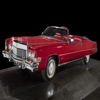

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The "Rock 'n' Roll Ride" exhibit at the Smithsonian's National Museum of African American History and Culture features a striking 1973 red Cadillac Eldorado that belonged to the legendary rock musician Chuck Berry. This exhibit is part of the broader "Musical Crossroads" exhibition, which explores the rich tapestry of music and its cultural significance. The Cadillac is particularly notable for its role in the 1987 documentary "Hail! Hail! Rock 'n' Roll," which celebrates Berry's life and music during two concerts for his 60th birthday. A poignant moment in the film shows Berry driving this Cadillac onto the stage of the Fox Theater in St. Louis, a venue that had previously denied him entry as a child due to ra

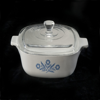

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a classic white casserole dish from CorningWare, dating back to 1965, adorned with the brand's iconic blue cornflower design. This dish is a testament to the evolution of kitchenware, as it was originally created from Pyroceram, a glass-ceramic material developed for military use during World War II. Its unique properties allowed it to withstand rapid temperature shifts while resisting stains and odors, making it a versatile choice for cooking, freezing, and serving. In the 1990s, CorningWare shifted towards ceramic stoneware to meet consumer demand for more colorful and varied designs, but the original glass-ceramic line made a comeback in 2009 due to popular demand. T

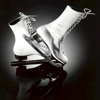

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the autographed ice skates of the legendary Sonja Henie, a prominent Norwegian figure skater from the early to mid-20th century. Henie is celebrated for her role in popularizing white leather ice skates during the 1920s and 1930s, a significant departure from the traditional black skates. She won her first world championship in 1927 and went on to achieve ten consecutive titles, captivating audiences with her unique blend of dance and skating. Henie's legacy includes three Olympic gold medals in the ladies singles event from the 1928, 1932, and 1936 Winter Olympics. Her transition to film in 1936, starring in productions like “One in a Million,” established her as one of Hollywood's top ac

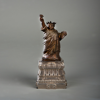

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features one of the earliest models of the Statue of Liberty, often referred to as the American Committee Model. Produced in the United States, this statuette was created in large quantities to support the construction of the statue's pedestal in New York Harbor. Designed by French sculptor Frédéric-Auguste Bartholdi, the models were made in both six-inch and twelve-inch sizes, with the six-inch version priced at one dollar and the twelve-inch version at five dollars. A national newspaper campaign successfully marketed these models, making them popular souvenirs while raising sufficient funds for the pedestal's construction. The completed statue, known as Liberty Enlightening the World, was dedicat

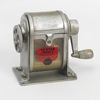

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Dexter Model 3 Pencil Sharpener, dating back to approximately 1920, manufactured by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. Constructed from metal, cellulose, and painted wood, this sharpener measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). As the back-to-school season approaches, this item may evoke fond memories of classroom experiences for many. The Dexter sharpener, which evolved from the original introduced in 1914, featured enhancements such as a rotating wheel with openings for various pencil sizes, addressing the needs of modern students. By the 1920s, APSCO had produced a diverse range of similar sharpeners, each with unique styles and

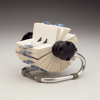

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Rolodex Open Rotary Card File, a quintessential office supply that has stood the test of time. Manufactured by the Rolodex Corporation in the USA, this item is made from a combination of bent tubular metal, molded plastic, rubber, and paper, with dimensions of 18 x 18 x 16.5 cm (7 1/16 x 7 1/16 x 6 1/2 in.). The Rolodex operates on a cylindrical mechanism that allows users to rotate through A-Z index cards, facilitating easy access to business contacts. Even in the digital age, the Rolodex remains a popular organizational tool, symbolizing a nostalgic yet enduring approach to information management. The creation of this innovative product is attributed to Arnold Neu

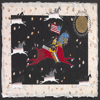

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the “Lakota Horse Mask,” a striking work by Jim Yellowhawk, a Cheyenne River Lakota artist, created in 2008 using acrylic on paper complemented by gold leaf. This piece exemplifies the essential relationship between American Indians and horses, often referred to as the Horse Nation, which played a vital role in their cultural practices. Horses have historically served as both companions in peaceful times and formidable allies in battle. Originally native to the Americas, horses became extinct in their home range but were reintroduced by Columbus in 1493, where they thrived. This artwork is part of the Smithsonian's National Museum of the American Indian collection and is featured in the onl

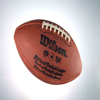

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wilson Duke football, a hallmark of American sports, which has been the official football of the Super Bowl since Super Bowl II in 1968. The featured football was used during Super Bowl XIV, which took place on January 20, 1980, at the Rose Bowl in Pasadena, California. In this championship game, the Pittsburgh Steelers emerged victorious against the Los Angeles Rams with a score of 31-19, securing their fourth Super Bowl win. Quarterback Terry Bradshaw's outstanding performance earned him the Most Valuable Player award for the second consecutive year. The Wilson Duke football is celebrated for its premium leather construction and durability, having been introduced by Wilson Sporting G

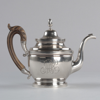

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a beautifully crafted silver teapot by Peter Bentzon, an American craftsman active from around 1783 to after 1850. The teapot, created circa 1817 to 1829, showcases an elegant oval vase shape that rests on a spreading pedestal foot. It is adorned with a gracefully curved spout, capped with an incised patera, and a scroll handle that features a wooden leaf cap. The hinged domed cover is topped with an acorn finial, enhancing its decorative appeal. The piece is engraved with the scripted monogram "MC" and bears the name "Rebecca Dawson" along its bottom rim, indicating its historical significance. This artifact is part of the Smithsonian National Museum of African American History and Cultur

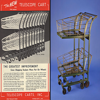

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit at the National Museum of American History features the Telescoping Shopping Cart, an invention that revolutionized shopping convenience created by Orla E. Watson in 1946. This cart, which made its debut in 1947 at Floyd's Super Market in Kansas City, Missouri, introduced a new way to shop by allowing multiple carts to nest together, thereby requiring only one-fifth of the space of a traditional cart when parked. This exhibit is part of the Smithsonian's first major showcase on food history, which highlights the significant shifts in food and dietary habits in postwar America. For more information on the evolution of food shopping and culinary innovations, visitors can explore the “FOOD: Transformin

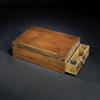

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary artifact: Thomas Jefferson's portable writing desk, which he used while drafting the Declaration of Independence in 1776. Designed by Jefferson himself, the desk includes a hinged writing board and a locking drawer for storing writing essentials. As a delegate from Virginia, Jefferson was chosen to draft this crucial document, which was adopted by the Continental Congress on July 4, marking a turning point in American history. The desk not only housed the initial drafts of this declaration but also bore witness to Jefferson's life as a statesman and president. In a heartfelt gesture, he gifted this desk to his granddaughter in 1825, after losing an earlier inlaid desk at s

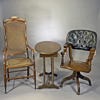

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an important artifact from the Civil War era: the chair used by General Ulysses S. Grant during the surrender negotiations with General Robert E. Lee on April 9, 1865, at Wilmer McLean's home in Appomattox Court House, Virginia. This meeting was crucial in determining the fate of Lee's troops and effectively marked the end of the Civil War. The chair, made of wood and measuring 37.5 inches in height, is a symbol of this historic event. After the surrender, Union officers took pieces of furniture as mementos, with Grant's chair and the table being notable examples. These items were later donated to the Smithsonian Institution and were reunited by 1915. This exhibit is part of the "Price of 

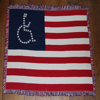

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a hand-altered lap blanket that incorporates the universal access symbol, a tribute to the advocacy efforts of the American Disabled for Attendant Programs Today (ADAPT). The blanket, made from cotton and measuring 129 cm by 95 cm, serves as a visual statement affirming the rights of individuals with disabilities. ADAPT, founded in 1983 in Denver, emerged from the broader disability rights movement that gained momentum after World War II, as individuals with disabilities began to unite in their fight against oppression. The stitched stars on this blanket emphasize the idea that civil rights are universal. Although this piece is currently not on display, it is part of the National Museum of

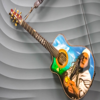

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the guitar of Carlos Vives, a Grammy Award-winning Colombian singer renowned for his vallenato music. Vallenato, a lively genre from Colombia's Atlantic coast, blends European instruments like the accordion with poetic storytelling and the traditional rhythms of the Arhuaco indigenous people. Historically, this music was performed by rural workers and cowboys, but in the 1990s, Vives and other artists innovatively fused it with pop and rock, thus expanding its reach throughout Latin America and among Latino communities in the United States. The guitar on display, handmade by a Colombian luthier, features an airbrushed portrait of an Arhuaco and was last played by Vives during a concert at 

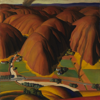

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a compelling painting by Ross Dickinson, an artist whose work emerged from the Public Works of Art Project during the Great Depression. His portrayal of California's Central Valley captures the lush greenery of farms meeting stark, dry hills, symbolizing the duality of beauty and danger inherent in the landscape. The small brushfire in the foreground and a larger plume of smoke in the distance serve as stark reminders of the wildfire risks that accompany the idyllic scene. Dickinson's work not only reflects the aspirational themes found in John Steinbeck's "The Grapes of Wrath" but also addresses the underlying tensions of hope amidst turmoil, making it a poignant reflection of life during

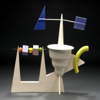

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the imaginative work of Peter Shire, an artist born in Los Angeles in 1947. Central to the display is the Weathervane Teapot, a striking piece characterized by its playful arrangement of colorful shapes, including squares and spheres, alongside whimsical rods and hollow tubes. Shire's goal with this teapot was to challenge and redefine the traditional, class-based perceptions of "tea-time," making it a more inclusive experience. The design invites interaction, yet it also leaves viewers questioning how to effectively pour from it, reflecting its borderline functionality. After 1985, Shire shifted his focus to furniture design, moving away from ceramic teapots. This piece is part of the Smi

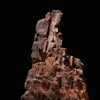

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Spotsylvania tree stump, a powerful artifact from the Civil War era, currently displayed at the Smithsonian's National Museum of American History. The stump, which dates back to 1864–65, was once part of a large oak tree located in a serene meadow near Spotsylvania Court House, Virginia. On May 12, 1864, this tranquil setting became the scene of a fierce battle between Confederate forces and Union troops, leading to the meadow being referred to as the Bloody Angle. The oak tree was severely damaged during the conflict, with several Minié balls still embedded in its wood, serving as a stark reminder of the violence that unfolded. The Battle of Spotsylvania Court House, which lasted from

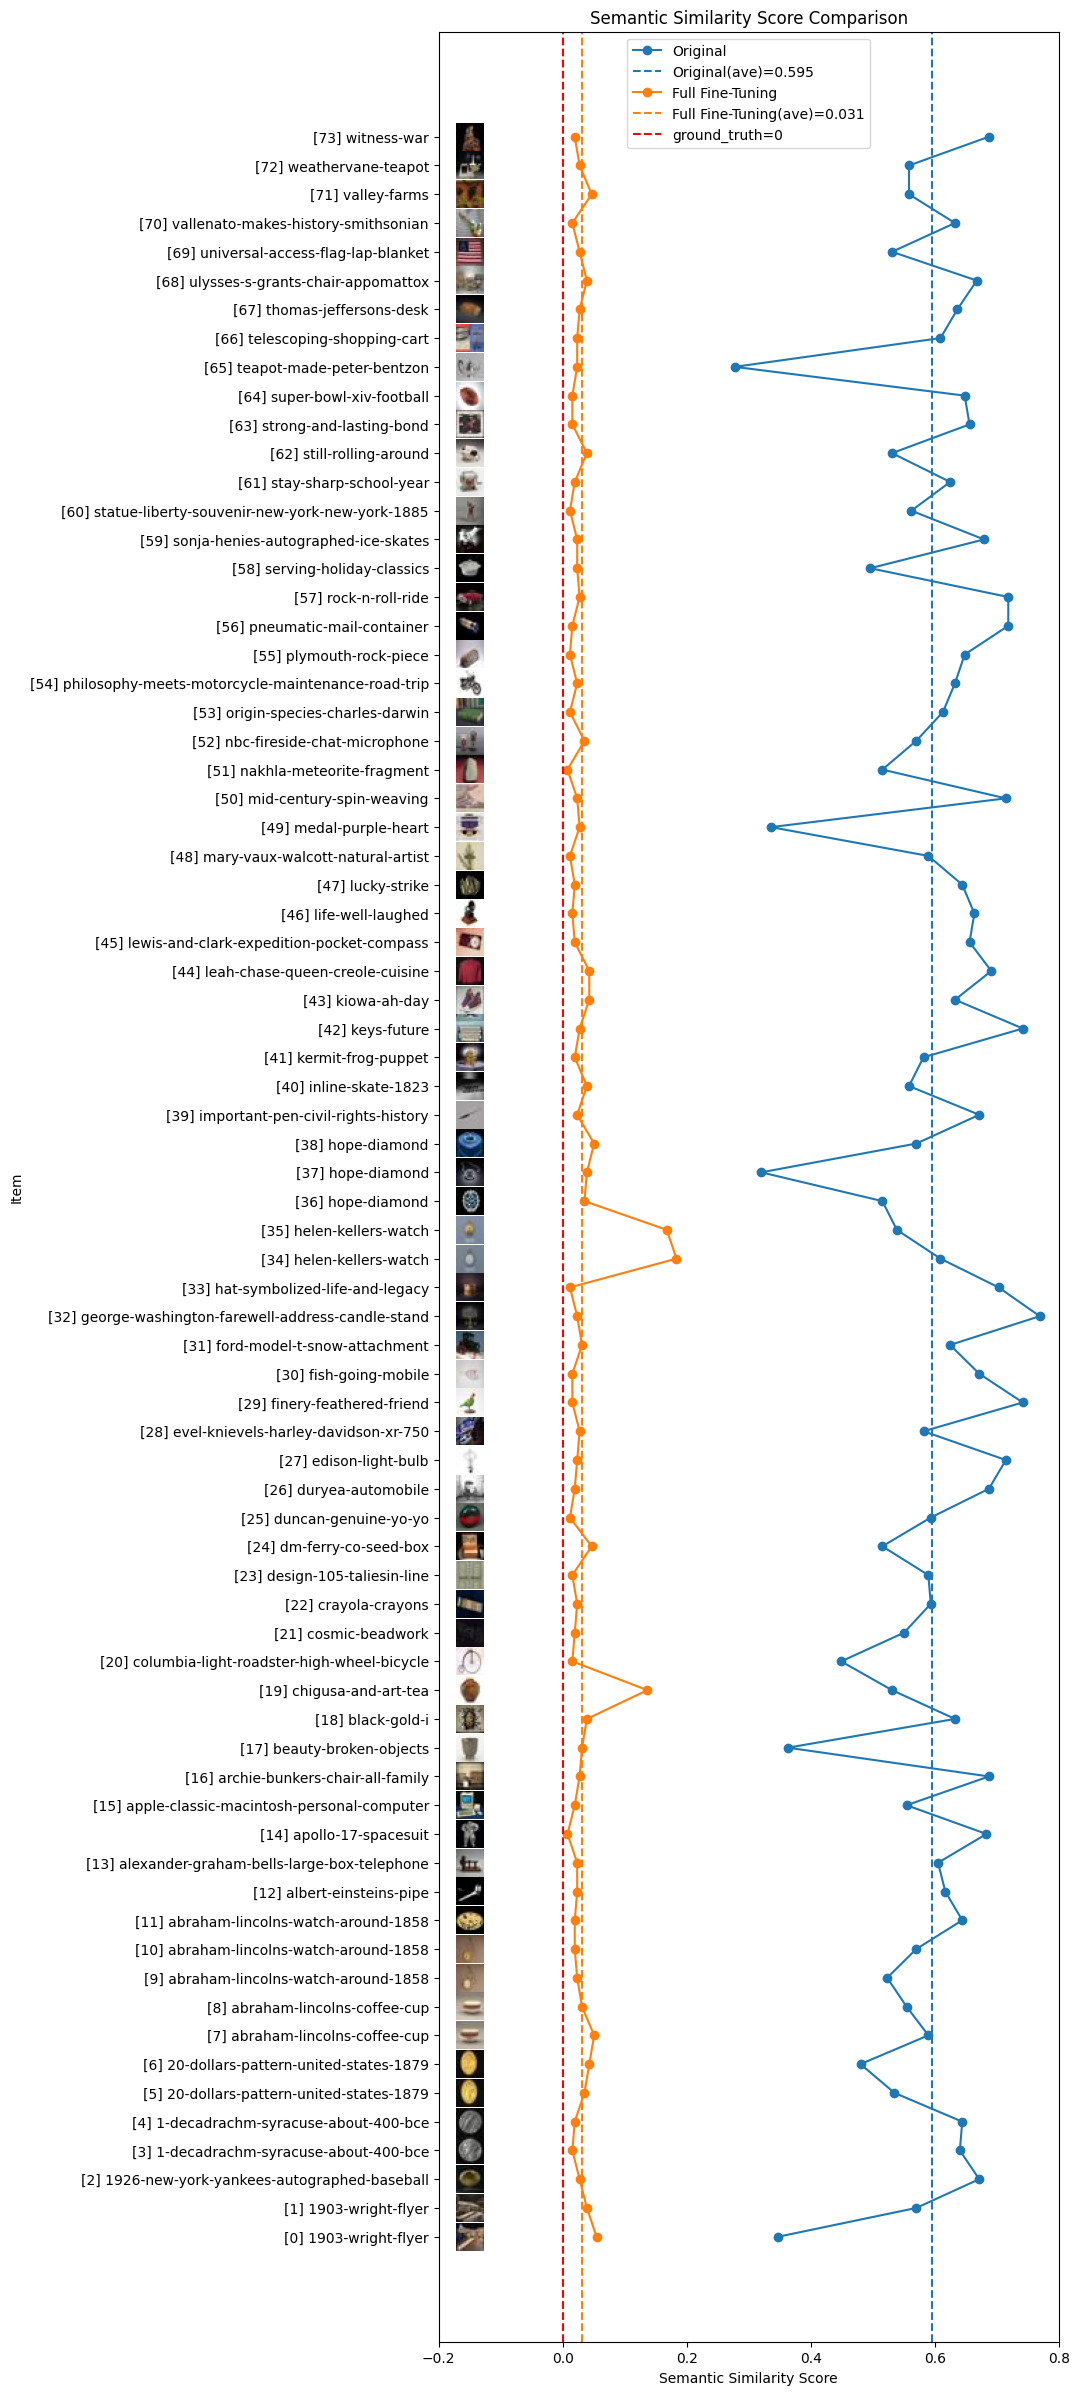

In [2]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(full_fine_tuning_model, processor, dataset['test'], './results/inference_results/inference_results_after_finetuning.csv', 10)

# Plot similarity scores (original vs. fine-tuned) from the inference CSV files, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv'),
                                 ('Full Fine-Tuning', './results/inference_results/inference_results_after_finetuning.csv')],
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_after_finetuning.jpg')


## 4.4 Save the Fine-Tuned Model Locally  

In [3]:
# Save processor
print(f'==> Saving processor...')
my_utils.print_processor_info_to_file(processor, './results/model_info/updated_processor_info.txt')
processor.save_pretrained(save_directory='./results/finetuned_model')

# Save fine-tuned model
print(f'==> Saving fine-tuned model...')
my_utils.print_model_info_to_file(full_fine_tuning_model, './results/model_info/finetuned_model_info.txt')
my_utils.print_model_parameters_to_file(full_fine_tuning_model, './results/model_info/finetuned_model_parameters.txt')
full_fine_tuning_model.save_pretrained(save_directory='./results/finetuned_model')


==> Saving processor...
==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32004, bos_token: <s>, eos_token: </s>, pad_token: <pad>
==> For complete processor info, refer to ./results/model_info/updated_processor_info.txt.
==> Saving fine-tuned model...
==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/finetuned_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, True)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, True)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.k_proj.weight (1327104, torch.bfloat16, cuda, True)
model.vision_m